<a href="https://colab.research.google.com/github/matla91/Examen-C-/blob/main/DeepLearning2AIR_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron (MLP)
auteur : [Maxime Devanne](https://www.maxime-devanne.com)

## Import des librairies

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

## Classification

### Jeu de données Pokemon Stats

#### Téléchargement du dataset

In [ ]:
!wget https://maxime-devanne.com/datasets/Pokemon_stats/pokemon-stats-data.csv

--2025-03-12 16:24:05--  https://maxime-devanne.com/datasets/Pokemon_stats/pokemon-stats-data.csv
Resolving maxime-devanne.com (maxime-devanne.com)... 213.186.33.4, 2001:41d0:1:1b00:213:186:33:4
Connecting to maxime-devanne.com (maxime-devanne.com)|213.186.33.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22598 (22K) [text/csv]
Saving to: ‘pokemon-stats-data.csv’

pokemon-stats-data. 100%[===================>]  22.07K   138KB/s    in 0.2s    

2025-03-12 16:24:06 (138 KB/s) - ‘pokemon-stats-data.csv’ saved [22598/22598]



#### Lecture du dataset

In [ ]:
df = pd.read_csv("pokemon-stats-data.csv")
df.head()

,name,weight_kg,speed,sp_attack,sp_defense,type
0,Bulbasaur,6.9,45,65,65,grass
1,Ivysaur,13.0,60,80,80,grass
2,Venusaur,100.0,80,122,120,grass
3,Charmander,8.5,65,60,50,fire
4,Charmeleon,19.0,80,80,65,fire


#### Préparation du jeu de données

##### Nettoyage

In [ ]:
df = df.dropna()

##### Réduction du jeu données en 3 classes
Nous utiliserons une version réduite du jeu de données avec seulement 3 classes :
- fairy
- ground
- flying

In [ ]:
df_types = df[(df["type"] !="test")]
types = df_types["type"].unique()

In [ ]:
df = df[(df["type"] == "fairy") | (df["type"] == "ground") | (df["type"] == "flying")]

##### Extraction des données d'entrée qui seront utilisées

Nous utiliserons les 4 attributs numériques :
- weight
- speed
- sp_attack
- sp_defense

In [ ]:
X = np.asarray(df[["weight_kg","speed","sp_attack","sp_defense"]], dtype=np.float32)
print(X.shape)

(48, 4)


##### Préparation des données de sortie (étiquettes de classes)
Dans le cas d'une classification multi-classes, il faut passer par une représentation en vecteur one-hot.

In [ ]:
y = np.asarray(df["type"])

le = LabelEncoder()
y = le.fit_transform(y)

ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1,1)).toarray()

print(y.shape)
print(y[0])

(48, 3)
[1. 0. 0.]


##### Séparation en train-test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=33/100, random_state=42)

##### Normalisation des données

Pour reproduire un cas réel, la normalisation est "apprise" sur le jeu d'entrainement seulement et ensuite appliquée sur les jeux de données d'apprentissage et de test.

In [ ]:
scaler = MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Construction d'un MLP

#### Couche d'entrée
Considère des entrées de même taille que celle d'une instance dans `x_train`

In [ ]:
input_shape = x_train.shape[1:]
input_layer = tf.keras.layers.Input(input_shape)

#### Couche cachée
Contient 16 neurones avec une activation `sigmoid`

In [ ]:
# the hidden layer is connected to the input layer
hidden_layer = tf.keras.layers.Dense(units=16, activation='sigmoid')(input_layer)

#### Couche de sortie
Contient un nombre de neurones égal au nombre de classes avec une activation `softmax`


In [ ]:
nb_classes = y_train.shape[1]
output_layer = tf.keras.layers.Dense(units=nb_classes,activation='softmax')(hidden_layer)

#### Création du modèle MLP
On spécifie uniquement la couche d'entrée et la couche de sortie

In [ ]:
model_mlp = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

#### Visualisation du modèle construit

In [ ]:
# textual information
model_mlp.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

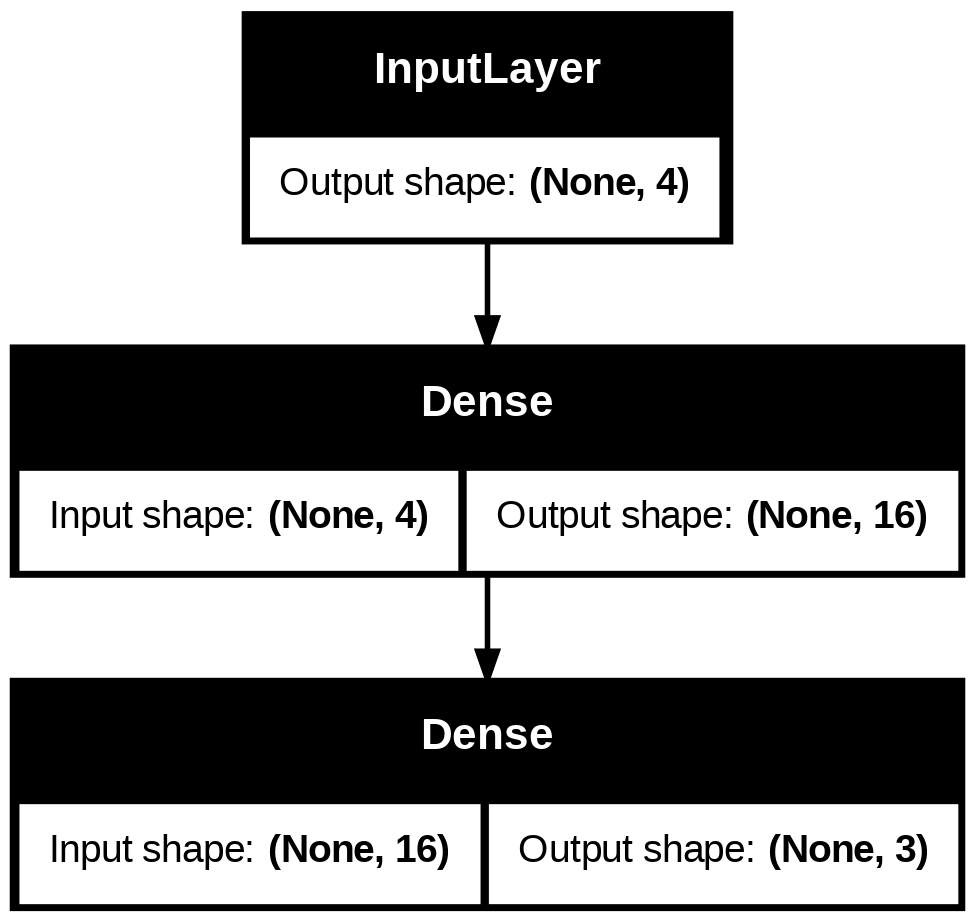

In [ ]:
# connected graph
tf.keras.utils.plot_model(model_mlp, show_shapes=True)

#### Compilation du modèle
Il faut notamment spécifier :
- l'algorithme d'optimisation avec un taux d'apprentissage (learning rate)
- la fonction de coût
- une métrique additionnelle (optionnel)

In [ ]:
# Optimizer : Adam
learning_rate = 0.001
optimizer_algo = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Cost function : Categorical Cross-Entropy
cost_function = tf.keras.losses.categorical_crossentropy

# Model compilation with the 'accuracy' as additional metric
model_mlp.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])

### Entrainement du MLP
Nous allons d'abord définir quelques hyper-paramètres :
- Nombre d'époques
- Taille de batch
- Pourcentage de données utilisées pour la validation
- Model Checkpoint pour garder le meilleur modèle sur la validation au cours de l'entrainement

In [ ]:
nb_epochs = 1000
mini_batch_size = 32
percentage_of_train_as_validation = 0.2
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best-model.h5', monitor='val_loss', save_best_only=True)

#### Lancement de l'entrainement
Il est possible de mettre le paramètre `verbose` à `False` afin de ne pas afficher le déroulé de chaque époque



**Soyez patient :)**

In [ ]:
history_mlp = model_mlp.fit(x_train,y_train,batch_size=mini_batch_size,
                    epochs=nb_epochs,verbose=True,
                    validation_split=percentage_of_train_as_validation,
                    callbacks=[model_checkpoint])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2000 - loss: 1.1327

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2000 - loss: 1.1327 - val_accuracy: 0.0000e+00 - val_loss: 1.1332
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.2400 - loss: 1.1260

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - accuracy: 0.2400 - loss: 1.1260 - val_accuracy: 0.1429 - val_loss: 1.1288
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2400 - loss: 1.1195

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2400 - loss: 1.1195 - val_accuracy: 0.1429 - val_loss: 1.1244
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2400 - loss: 1.1131

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2400 - loss: 1.1131 - val_accuracy: 0.1429 - val_loss: 1.1202
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2800 - loss: 1.1068

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2800 - loss: 1.1068 - val_accuracy: 0.2857 - val_loss: 1.1161
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2800 - loss: 1.1006

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2800 - loss: 1.1006 - val_accuracy: 0.4286 - val_loss: 1.1120
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3200 - loss: 1.0945

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3200 - loss: 1.0945 - val_accuracy: 0.4286 - val_loss: 1.1081
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3200 - loss: 1.0885

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3200 - loss: 1.0885 - val_accuracy: 0.4286 - val_loss: 1.1043
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4000 - loss: 1.0827

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4000 - loss: 1.0827 - val_accuracy: 0.4286 - val_loss: 1.1006
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4000 - loss: 1.0769

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4000 - loss: 1.0769 - val_accuracy: 0.4286 - val_loss: 1.0970
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4000 - loss: 1.0713

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4000 - loss: 1.0713 - val_accuracy: 0.4286 - val_loss: 1.0935
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4000 - loss: 1.0657

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4000 - loss: 1.0657 - val_accuracy: 0.4286 - val_loss: 1.0902
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4400 - loss: 1.0603

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4400 - loss: 1.0603 - val_accuracy: 0.4286 - val_loss: 1.0869
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4400 - loss: 1.0550

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4400 - loss: 1.0550 - val_accuracy: 0.4286 - val_loss: 1.0837
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4400 - loss: 1.0498

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4400 - loss: 1.0498 - val_accuracy: 0.4286 - val_loss: 1.0806
Epoch 16/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4400 - loss: 1.0447

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4400 - loss: 1.0447 - val_accuracy: 0.4286 - val_loss: 1.0776
Epoch 17/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4400 - loss: 1.0397

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4400 - loss: 1.0397 - val_accuracy: 0.4286 - val_loss: 1.0747
Epoch 18/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4400 - loss: 1.0349

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4400 - loss: 1.0349 - val_accuracy: 0.4286 - val_loss: 1.0719
Epoch 19/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4400 - loss: 1.0301

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4400 - loss: 1.0301 - val_accuracy: 0.4286 - val_loss: 1.0692
Epoch 20/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4400 - loss: 1.0254

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4400 - loss: 1.0254 - val_accuracy: 0.4286 - val_loss: 1.0666
Epoch 21/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4400 - loss: 1.0209

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4400 - loss: 1.0209 - val_accuracy: 0.4286 - val_loss: 1.0641
Epoch 22/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4400 - loss: 1.0164

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4400 - loss: 1.0164 - val_accuracy: 0.4286 - val_loss: 1.0617
Epoch 23/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4400 - loss: 1.0121

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4400 - loss: 1.0121 - val_accuracy: 0.4286 - val_loss: 1.0593
Epoch 24/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4400 - loss: 1.0078

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4400 - loss: 1.0078 - val_accuracy: 0.4286 - val_loss: 1.0570
Epoch 25/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4400 - loss: 1.0036

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4400 - loss: 1.0036 - val_accuracy: 0.4286 - val_loss: 1.0548
Epoch 26/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4400 - loss: 0.9996

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4400 - loss: 0.9996 - val_accuracy: 0.4286 - val_loss: 1.0527
Epoch 27/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4400 - loss: 0.9956

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4400 - loss: 0.9956 - val_accuracy: 0.4286 - val_loss: 1.0507
Epoch 28/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4400 - loss: 0.9917

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4400 - loss: 0.9917 - val_accuracy: 0.4286 - val_loss: 1.0488
Epoch 29/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4400 - loss: 0.9879

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4400 - loss: 0.9879 - val_accuracy: 0.4286 - val_loss: 1.0469
Epoch 30/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4400 - loss: 0.9842

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.4400 - loss: 0.9842 - val_accuracy: 0.4286 - val_loss: 1.0451
Epoch 31/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4400 - loss: 0.9805

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4400 - loss: 0.9805 - val_accuracy: 0.4286 - val_loss: 1.0433
Epoch 32/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4400 - loss: 0.9770

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4400 - loss: 0.9770 - val_accuracy: 0.4286 - val_loss: 1.0416
Epoch 33/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4400 - loss: 0.9735

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4400 - loss: 0.9735 - val_accuracy: 0.4286 - val_loss: 1.0400
Epoch 34/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4400 - loss: 0.9702

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4400 - loss: 0.9702 - val_accuracy: 0.4286 - val_loss: 1.0385
Epoch 35/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4400 - loss: 0.9669

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4400 - loss: 0.9669 - val_accuracy: 0.4286 - val_loss: 1.0370
Epoch 36/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4400 - loss: 0.9636

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4400 - loss: 0.9636 - val_accuracy: 0.4286 - val_loss: 1.0356
Epoch 37/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5200 - loss: 0.9605

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5200 - loss: 0.9605 - val_accuracy: 0.4286 - val_loss: 1.0342
Epoch 38/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5200 - loss: 0.9574

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5200 - loss: 0.9574 - val_accuracy: 0.4286 - val_loss: 1.0329
Epoch 39/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5200 - loss: 0.9544

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5200 - loss: 0.9544 - val_accuracy: 0.4286 - val_loss: 1.0316
Epoch 40/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5200 - loss: 0.9514

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5200 - loss: 0.9514 - val_accuracy: 0.4286 - val_loss: 1.0304
Epoch 41/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5200 - loss: 0.9486

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5200 - loss: 0.9486 - val_accuracy: 0.4286 - val_loss: 1.0292
Epoch 42/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5200 - loss: 0.9457

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5200 - loss: 0.9457 - val_accuracy: 0.4286 - val_loss: 1.0281
Epoch 43/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5200 - loss: 0.9430

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5200 - loss: 0.9430 - val_accuracy: 0.4286 - val_loss: 1.0270
Epoch 44/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5200 - loss: 0.9403

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5200 - loss: 0.9403 - val_accuracy: 0.4286 - val_loss: 1.0260
Epoch 45/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5200 - loss: 0.9377

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5200 - loss: 0.9377 - val_accuracy: 0.4286 - val_loss: 1.0250
Epoch 46/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5200 - loss: 0.9351

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5200 - loss: 0.9351 - val_accuracy: 0.4286 - val_loss: 1.0240
Epoch 47/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5200 - loss: 0.9326

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5200 - loss: 0.9326 - val_accuracy: 0.4286 - val_loss: 1.0231
Epoch 48/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5200 - loss: 0.9301

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5200 - loss: 0.9301 - val_accuracy: 0.4286 - val_loss: 1.0223
Epoch 49/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5200 - loss: 0.9277

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5200 - loss: 0.9277 - val_accuracy: 0.4286 - val_loss: 1.0214
Epoch 50/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5200 - loss: 0.9254

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5200 - loss: 0.9254 - val_accuracy: 0.4286 - val_loss: 1.0206
Epoch 51/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5200 - loss: 0.9231

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5200 - loss: 0.9231 - val_accuracy: 0.4286 - val_loss: 1.0199
Epoch 52/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5200 - loss: 0.9208

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5200 - loss: 0.9208 - val_accuracy: 0.4286 - val_loss: 1.0191
Epoch 53/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5200 - loss: 0.9187

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5200 - loss: 0.9187 - val_accuracy: 0.4286 - val_loss: 1.0185
Epoch 54/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5200 - loss: 0.9165

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5200 - loss: 0.9165 - val_accuracy: 0.4286 - val_loss: 1.0178
Epoch 55/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5200 - loss: 0.9144

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5200 - loss: 0.9144 - val_accuracy: 0.4286 - val_loss: 1.0172
Epoch 56/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5200 - loss: 0.9123

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5200 - loss: 0.9123 - val_accuracy: 0.4286 - val_loss: 1.0166
Epoch 57/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5200 - loss: 0.9103

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5200 - loss: 0.9103 - val_accuracy: 0.4286 - val_loss: 1.0160
Epoch 58/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5200 - loss: 0.9084

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5200 - loss: 0.9084 - val_accuracy: 0.4286 - val_loss: 1.0155
Epoch 59/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4800 - loss: 0.9064

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4800 - loss: 0.9064 - val_accuracy: 0.4286 - val_loss: 1.0150
Epoch 60/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5200 - loss: 0.9046

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5200 - loss: 0.9046 - val_accuracy: 0.4286 - val_loss: 1.0145
Epoch 61/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5200 - loss: 0.9027

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5200 - loss: 0.9027 - val_accuracy: 0.4286 - val_loss: 1.0140
Epoch 62/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5600 - loss: 0.9009

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5600 - loss: 0.9009 - val_accuracy: 0.4286 - val_loss: 1.0136
Epoch 63/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5600 - loss: 0.8991

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5600 - loss: 0.8991 - val_accuracy: 0.4286 - val_loss: 1.0132
Epoch 64/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5600 - loss: 0.8974

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5600 - loss: 0.8974 - val_accuracy: 0.4286 - val_loss: 1.0128
Epoch 65/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5600 - loss: 0.8957

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5600 - loss: 0.8957 - val_accuracy: 0.4286 - val_loss: 1.0124
Epoch 66/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5600 - loss: 0.8941

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5600 - loss: 0.8941 - val_accuracy: 0.4286 - val_loss: 1.0121
Epoch 67/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5600 - loss: 0.8925

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5600 - loss: 0.8925 - val_accuracy: 0.5714 - val_loss: 1.0118
Epoch 68/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5200 - loss: 0.8909

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5200 - loss: 0.8909 - val_accuracy: 0.4286 - val_loss: 1.0115
Epoch 69/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4800 - loss: 0.8893

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4800 - loss: 0.8893 - val_accuracy: 0.4286 - val_loss: 1.0112
Epoch 70/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4800 - loss: 0.8878

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4800 - loss: 0.8878 - val_accuracy: 0.4286 - val_loss: 1.0110
Epoch 71/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4400 - loss: 0.8863

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4400 - loss: 0.8863 - val_accuracy: 0.4286 - val_loss: 1.0107
Epoch 72/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4400 - loss: 0.8849

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4400 - loss: 0.8849 - val_accuracy: 0.4286 - val_loss: 1.0105
Epoch 73/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4800 - loss: 0.8834

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4800 - loss: 0.8834 - val_accuracy: 0.4286 - val_loss: 1.0103
Epoch 74/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5200 - loss: 0.8820

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5200 - loss: 0.8820 - val_accuracy: 0.5714 - val_loss: 1.0101
Epoch 75/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5200 - loss: 0.8807

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5200 - loss: 0.8807 - val_accuracy: 0.5714 - val_loss: 1.0100
Epoch 76/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5200 - loss: 0.8793

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5200 - loss: 0.8793 - val_accuracy: 0.5714 - val_loss: 1.0098
Epoch 77/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5200 - loss: 0.8780

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5200 - loss: 0.8780 - val_accuracy: 0.4286 - val_loss: 1.0097
Epoch 78/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5200 - loss: 0.8767

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5200 - loss: 0.8767 - val_accuracy: 0.4286 - val_loss: 1.0096
Epoch 79/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5200 - loss: 0.8755

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5200 - loss: 0.8755 - val_accuracy: 0.4286 - val_loss: 1.0095
Epoch 80/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5600 - loss: 0.8743

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5600 - loss: 0.8743 - val_accuracy: 0.4286 - val_loss: 1.0094
Epoch 81/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5600 - loss: 0.8730

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5600 - loss: 0.8730 - val_accuracy: 0.4286 - val_loss: 1.0093
Epoch 82/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6000 - loss: 0.8719

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6000 - loss: 0.8719 - val_accuracy: 0.4286 - val_loss: 1.0092
Epoch 83/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6000 - loss: 0.8707

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6000 - loss: 0.8707 - val_accuracy: 0.4286 - val_loss: 1.0092
Epoch 84/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6400 - loss: 0.8696

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6400 - loss: 0.8696 - val_accuracy: 0.4286 - val_loss: 1.0091
Epoch 85/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6000 - loss: 0.8684

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6000 - loss: 0.8684 - val_accuracy: 0.4286 - val_loss: 1.0091
Epoch 86/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6000 - loss: 0.8673

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6000 - loss: 0.8673 - val_accuracy: 0.4286 - val_loss: 1.0091
Epoch 87/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6000 - loss: 0.8663

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6000 - loss: 0.8663 - val_accuracy: 0.5714 - val_loss: 1.0091
Epoch 88/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5600 - loss: 0.8652 - val_accuracy: 0.5714 - val_loss: 1.0091
Epoch 89/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5600 - loss: 0.8642 - val_accuracy: 0.5714 - val_loss: 1.0091
Epoch 90/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5600 - loss: 0.8632 - val_accuracy: 0.5714 - val_loss: 1.0091
Epoch 91/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5600 - loss: 0.8622 - val_accuracy: 0.5714 - val_loss: 1.0092
Epoch 92/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5200 - loss: 0.8612 - val_accuracy: 0.5714 - val_loss: 1.0092
Epoch 93/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6000 - loss: 0.8602 - val_accuracy: 0.5714 - val_loss: 1.0092
Epoch 94/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6000 - loss: 0.8593 - val_accuracy: 0.4286 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6800 - loss: 0.7638 - val_accuracy: 0.7143 - val_loss: 1.0090
Epoch 328/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6800 - loss: 0.7634

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6800 - loss: 0.7634 - val_accuracy: 0.7143 - val_loss: 1.0088
Epoch 329/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6800 - loss: 0.7631

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6800 - loss: 0.7631 - val_accuracy: 0.7143 - val_loss: 1.0085
Epoch 330/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6800 - loss: 0.7627

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6800 - loss: 0.7627 - val_accuracy: 0.7143 - val_loss: 1.0083
Epoch 331/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6800 - loss: 0.7624

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6800 - loss: 0.7624 - val_accuracy: 0.7143 - val_loss: 1.0081
Epoch 332/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6800 - loss: 0.7620

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6800 - loss: 0.7620 - val_accuracy: 0.7143 - val_loss: 1.0078
Epoch 333/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7200 - loss: 0.7617

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7200 - loss: 0.7617 - val_accuracy: 0.7143 - val_loss: 1.0076
Epoch 334/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.7613

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7200 - loss: 0.7613 - val_accuracy: 0.7143 - val_loss: 1.0074
Epoch 335/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.7610

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7200 - loss: 0.7610 - val_accuracy: 0.7143 - val_loss: 1.0071
Epoch 336/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7606

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7200 - loss: 0.7606 - val_accuracy: 0.7143 - val_loss: 1.0069
Epoch 337/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7200 - loss: 0.7603

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7200 - loss: 0.7603 - val_accuracy: 0.7143 - val_loss: 1.0067
Epoch 338/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7200 - loss: 0.7599

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7200 - loss: 0.7599 - val_accuracy: 0.7143 - val_loss: 1.0064
Epoch 339/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7200 - loss: 0.7596

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7200 - loss: 0.7596 - val_accuracy: 0.7143 - val_loss: 1.0062
Epoch 340/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7200 - loss: 0.7592

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7200 - loss: 0.7592 - val_accuracy: 0.7143 - val_loss: 1.0059
Epoch 341/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7589

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7200 - loss: 0.7589 - val_accuracy: 0.7143 - val_loss: 1.0057
Epoch 342/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7200 - loss: 0.7585

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7200 - loss: 0.7585 - val_accuracy: 0.7143 - val_loss: 1.0054
Epoch 343/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7200 - loss: 0.7582

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7200 - loss: 0.7582 - val_accuracy: 0.7143 - val_loss: 1.0052
Epoch 344/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7200 - loss: 0.7578

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7200 - loss: 0.7578 - val_accuracy: 0.7143 - val_loss: 1.0049
Epoch 345/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.7574

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7200 - loss: 0.7574 - val_accuracy: 0.7143 - val_loss: 1.0047
Epoch 346/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7200 - loss: 0.7571

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7200 - loss: 0.7571 - val_accuracy: 0.7143 - val_loss: 1.0044
Epoch 347/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7567

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7200 - loss: 0.7567 - val_accuracy: 0.7143 - val_loss: 1.0042
Epoch 348/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7564

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7200 - loss: 0.7564 - val_accuracy: 0.7143 - val_loss: 1.0039
Epoch 349/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7200 - loss: 0.7560

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7200 - loss: 0.7560 - val_accuracy: 0.7143 - val_loss: 1.0036
Epoch 350/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7200 - loss: 0.7556

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7200 - loss: 0.7556 - val_accuracy: 0.7143 - val_loss: 1.0034
Epoch 351/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7200 - loss: 0.7553

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7200 - loss: 0.7553 - val_accuracy: 0.7143 - val_loss: 1.0031
Epoch 352/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7549

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7200 - loss: 0.7549 - val_accuracy: 0.7143 - val_loss: 1.0029
Epoch 353/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7546

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7200 - loss: 0.7546 - val_accuracy: 0.7143 - val_loss: 1.0026
Epoch 354/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7200 - loss: 0.7542

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7200 - loss: 0.7542 - val_accuracy: 0.7143 - val_loss: 1.0023
Epoch 355/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.7538

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7200 - loss: 0.7538 - val_accuracy: 0.7143 - val_loss: 1.0021
Epoch 356/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7200 - loss: 0.7535

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7200 - loss: 0.7535 - val_accuracy: 0.7143 - val_loss: 1.0018
Epoch 357/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7531

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7200 - loss: 0.7531 - val_accuracy: 0.7143 - val_loss: 1.0015
Epoch 358/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7200 - loss: 0.7528

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7200 - loss: 0.7528 - val_accuracy: 0.7143 - val_loss: 1.0012
Epoch 359/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7200 - loss: 0.7524

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7200 - loss: 0.7524 - val_accuracy: 0.7143 - val_loss: 1.0010
Epoch 360/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7200 - loss: 0.7520

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7200 - loss: 0.7520 - val_accuracy: 0.7143 - val_loss: 1.0007
Epoch 361/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7200 - loss: 0.7517

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7200 - loss: 0.7517 - val_accuracy: 0.7143 - val_loss: 1.0004
Epoch 362/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7200 - loss: 0.7513

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7200 - loss: 0.7513 - val_accuracy: 0.7143 - val_loss: 1.0001
Epoch 363/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7509

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7200 - loss: 0.7509 - val_accuracy: 0.7143 - val_loss: 0.9999
Epoch 364/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7200 - loss: 0.7506

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7200 - loss: 0.7506 - val_accuracy: 0.7143 - val_loss: 0.9996
Epoch 365/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7200 - loss: 0.7502

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7200 - loss: 0.7502 - val_accuracy: 0.7143 - val_loss: 0.9993
Epoch 366/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7498

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7200 - loss: 0.7498 - val_accuracy: 0.7143 - val_loss: 0.9990
Epoch 367/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7200 - loss: 0.7495

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7200 - loss: 0.7495 - val_accuracy: 0.7143 - val_loss: 0.9987
Epoch 368/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7200 - loss: 0.7491

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7200 - loss: 0.7491 - val_accuracy: 0.7143 - val_loss: 0.9984
Epoch 369/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7487

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7200 - loss: 0.7487 - val_accuracy: 0.7143 - val_loss: 0.9981
Epoch 370/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7200 - loss: 0.7484

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7200 - loss: 0.7484 - val_accuracy: 0.7143 - val_loss: 0.9979
Epoch 371/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7200 - loss: 0.7480

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7200 - loss: 0.7480 - val_accuracy: 0.7143 - val_loss: 0.9976
Epoch 372/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7476

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7200 - loss: 0.7476 - val_accuracy: 0.7143 - val_loss: 0.9973
Epoch 373/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7472

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7200 - loss: 0.7472 - val_accuracy: 0.7143 - val_loss: 0.9970
Epoch 374/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7469

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7200 - loss: 0.7469 - val_accuracy: 0.7143 - val_loss: 0.9967
Epoch 375/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7465

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7200 - loss: 0.7465 - val_accuracy: 0.7143 - val_loss: 0.9964
Epoch 376/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7461

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7200 - loss: 0.7461 - val_accuracy: 0.7143 - val_loss: 0.9961
Epoch 377/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7457

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7200 - loss: 0.7457 - val_accuracy: 0.7143 - val_loss: 0.9958
Epoch 378/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7454

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7200 - loss: 0.7454 - val_accuracy: 0.7143 - val_loss: 0.9955
Epoch 379/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7200 - loss: 0.7450

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7200 - loss: 0.7450 - val_accuracy: 0.7143 - val_loss: 0.9952
Epoch 380/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7200 - loss: 0.7446

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7200 - loss: 0.7446 - val_accuracy: 0.7143 - val_loss: 0.9949
Epoch 381/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7200 - loss: 0.7442

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7200 - loss: 0.7442 - val_accuracy: 0.7143 - val_loss: 0.9946
Epoch 382/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7200 - loss: 0.7439

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7200 - loss: 0.7439 - val_accuracy: 0.7143 - val_loss: 0.9942
Epoch 383/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7200 - loss: 0.7435

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7200 - loss: 0.7435 - val_accuracy: 0.7143 - val_loss: 0.9939
Epoch 384/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7200 - loss: 0.7431

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7200 - loss: 0.7431 - val_accuracy: 0.7143 - val_loss: 0.9936
Epoch 385/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7200 - loss: 0.7427

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7200 - loss: 0.7427 - val_accuracy: 0.7143 - val_loss: 0.9933
Epoch 386/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7200 - loss: 0.7424

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7200 - loss: 0.7424 - val_accuracy: 0.7143 - val_loss: 0.9930
Epoch 387/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7200 - loss: 0.7420

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7200 - loss: 0.7420 - val_accuracy: 0.7143 - val_loss: 0.9927
Epoch 388/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7200 - loss: 0.7416

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7200 - loss: 0.7416 - val_accuracy: 0.7143 - val_loss: 0.9924
Epoch 389/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7200 - loss: 0.7412

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7200 - loss: 0.7412 - val_accuracy: 0.7143 - val_loss: 0.9921
Epoch 390/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7200 - loss: 0.7408

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7200 - loss: 0.7408 - val_accuracy: 0.7143 - val_loss: 0.9917
Epoch 391/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7200 - loss: 0.7405

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7200 - loss: 0.7405 - val_accuracy: 0.7143 - val_loss: 0.9914
Epoch 392/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7200 - loss: 0.7401

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7200 - loss: 0.7401 - val_accuracy: 0.7143 - val_loss: 0.9911
Epoch 393/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7397

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7200 - loss: 0.7397 - val_accuracy: 0.7143 - val_loss: 0.9908
Epoch 394/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7393

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7200 - loss: 0.7393 - val_accuracy: 0.7143 - val_loss: 0.9904
Epoch 395/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7200 - loss: 0.7389

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7200 - loss: 0.7389 - val_accuracy: 0.7143 - val_loss: 0.9901
Epoch 396/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7385

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7200 - loss: 0.7385 - val_accuracy: 0.7143 - val_loss: 0.9898
Epoch 397/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7200 - loss: 0.7382

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7200 - loss: 0.7382 - val_accuracy: 0.7143 - val_loss: 0.9895
Epoch 398/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7378

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7200 - loss: 0.7378 - val_accuracy: 0.7143 - val_loss: 0.9891
Epoch 399/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7200 - loss: 0.7374

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7200 - loss: 0.7374 - val_accuracy: 0.7143 - val_loss: 0.9888
Epoch 400/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.7370

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7200 - loss: 0.7370 - val_accuracy: 0.7143 - val_loss: 0.9885
Epoch 401/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7200 - loss: 0.7366

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7200 - loss: 0.7366 - val_accuracy: 0.7143 - val_loss: 0.9881
Epoch 402/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7200 - loss: 0.7362

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7200 - loss: 0.7362 - val_accuracy: 0.7143 - val_loss: 0.9878
Epoch 403/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.7358

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7200 - loss: 0.7358 - val_accuracy: 0.7143 - val_loss: 0.9875
Epoch 404/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7200 - loss: 0.7355

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7200 - loss: 0.7355 - val_accuracy: 0.7143 - val_loss: 0.9871
Epoch 405/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7351

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7200 - loss: 0.7351 - val_accuracy: 0.7143 - val_loss: 0.9868
Epoch 406/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7347

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7200 - loss: 0.7347 - val_accuracy: 0.7143 - val_loss: 0.9865
Epoch 407/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7200 - loss: 0.7343

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7200 - loss: 0.7343 - val_accuracy: 0.7143 - val_loss: 0.9861
Epoch 408/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7200 - loss: 0.7339

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7200 - loss: 0.7339 - val_accuracy: 0.7143 - val_loss: 0.9858
Epoch 409/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7200 - loss: 0.7335

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7200 - loss: 0.7335 - val_accuracy: 0.7143 - val_loss: 0.9854
Epoch 410/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7200 - loss: 0.7331

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7200 - loss: 0.7331 - val_accuracy: 0.7143 - val_loss: 0.9851
Epoch 411/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7327

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7200 - loss: 0.7327 - val_accuracy: 0.7143 - val_loss: 0.9847
Epoch 412/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7323

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7200 - loss: 0.7323 - val_accuracy: 0.7143 - val_loss: 0.9844
Epoch 413/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7320

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7200 - loss: 0.7320 - val_accuracy: 0.7143 - val_loss: 0.9840
Epoch 414/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7200 - loss: 0.7316

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7200 - loss: 0.7316 - val_accuracy: 0.7143 - val_loss: 0.9837
Epoch 415/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7200 - loss: 0.7312

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7200 - loss: 0.7312 - val_accuracy: 0.7143 - val_loss: 0.9833
Epoch 416/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7308

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7200 - loss: 0.7308 - val_accuracy: 0.7143 - val_loss: 0.9830
Epoch 417/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7304

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7200 - loss: 0.7304 - val_accuracy: 0.7143 - val_loss: 0.9826
Epoch 418/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7200 - loss: 0.7300

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7200 - loss: 0.7300 - val_accuracy: 0.7143 - val_loss: 0.9823
Epoch 419/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7296

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7200 - loss: 0.7296 - val_accuracy: 0.7143 - val_loss: 0.9819
Epoch 420/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7292

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7200 - loss: 0.7292 - val_accuracy: 0.7143 - val_loss: 0.9816
Epoch 421/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7288

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7200 - loss: 0.7288 - val_accuracy: 0.7143 - val_loss: 0.9812
Epoch 422/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7200 - loss: 0.7284

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7200 - loss: 0.7284 - val_accuracy: 0.7143 - val_loss: 0.9809
Epoch 423/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7200 - loss: 0.7280

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7200 - loss: 0.7280 - val_accuracy: 0.7143 - val_loss: 0.9805
Epoch 424/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7276

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7200 - loss: 0.7276 - val_accuracy: 0.7143 - val_loss: 0.9801
Epoch 425/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7200 - loss: 0.7272

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7200 - loss: 0.7272 - val_accuracy: 0.7143 - val_loss: 0.9798
Epoch 426/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7200 - loss: 0.7268

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7200 - loss: 0.7268 - val_accuracy: 0.7143 - val_loss: 0.9794
Epoch 427/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7200 - loss: 0.7264

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7200 - loss: 0.7264 - val_accuracy: 0.7143 - val_loss: 0.9790
Epoch 428/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7260

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7200 - loss: 0.7260 - val_accuracy: 0.7143 - val_loss: 0.9787
Epoch 429/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7256

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7200 - loss: 0.7256 - val_accuracy: 0.7143 - val_loss: 0.9783
Epoch 430/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7252

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7200 - loss: 0.7252 - val_accuracy: 0.7143 - val_loss: 0.9779
Epoch 431/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7200 - loss: 0.7248

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7200 - loss: 0.7248 - val_accuracy: 0.7143 - val_loss: 0.9776
Epoch 432/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7200 - loss: 0.7244

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7200 - loss: 0.7244 - val_accuracy: 0.7143 - val_loss: 0.9772
Epoch 433/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7200 - loss: 0.7240

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7200 - loss: 0.7240 - val_accuracy: 0.7143 - val_loss: 0.9768
Epoch 434/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7236

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7200 - loss: 0.7236 - val_accuracy: 0.7143 - val_loss: 0.9765
Epoch 435/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7200 - loss: 0.7232

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7200 - loss: 0.7232 - val_accuracy: 0.7143 - val_loss: 0.9761
Epoch 436/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7228

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7200 - loss: 0.7228 - val_accuracy: 0.7143 - val_loss: 0.9757
Epoch 437/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7200 - loss: 0.7224

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7200 - loss: 0.7224 - val_accuracy: 0.7143 - val_loss: 0.9753
Epoch 438/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7220

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7200 - loss: 0.7220 - val_accuracy: 0.7143 - val_loss: 0.9750
Epoch 439/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7200 - loss: 0.7216

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7200 - loss: 0.7216 - val_accuracy: 0.7143 - val_loss: 0.9746
Epoch 440/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7200 - loss: 0.7212

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7200 - loss: 0.7212 - val_accuracy: 0.7143 - val_loss: 0.9742
Epoch 441/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7208

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7200 - loss: 0.7208 - val_accuracy: 0.7143 - val_loss: 0.9738
Epoch 442/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7204

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7200 - loss: 0.7204 - val_accuracy: 0.7143 - val_loss: 0.9734
Epoch 443/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7200

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7200 - loss: 0.7200 - val_accuracy: 0.7143 - val_loss: 0.9731
Epoch 444/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7200 - loss: 0.7196

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7200 - loss: 0.7196 - val_accuracy: 0.7143 - val_loss: 0.9727
Epoch 445/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.7192

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7200 - loss: 0.7192 - val_accuracy: 0.7143 - val_loss: 0.9723
Epoch 446/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7188

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7200 - loss: 0.7188 - val_accuracy: 0.7143 - val_loss: 0.9719
Epoch 447/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7184

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7200 - loss: 0.7184 - val_accuracy: 0.7143 - val_loss: 0.9715
Epoch 448/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7200 - loss: 0.7180

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7200 - loss: 0.7180 - val_accuracy: 0.7143 - val_loss: 0.9711
Epoch 449/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7200 - loss: 0.7176

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7200 - loss: 0.7176 - val_accuracy: 0.7143 - val_loss: 0.9707
Epoch 450/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7172

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7200 - loss: 0.7172 - val_accuracy: 0.7143 - val_loss: 0.9703
Epoch 451/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7200 - loss: 0.7167

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7200 - loss: 0.7167 - val_accuracy: 0.7143 - val_loss: 0.9700
Epoch 452/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7200 - loss: 0.7163

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7200 - loss: 0.7163 - val_accuracy: 0.7143 - val_loss: 0.9696
Epoch 453/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7200 - loss: 0.7159

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7200 - loss: 0.7159 - val_accuracy: 0.7143 - val_loss: 0.9692
Epoch 454/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7155

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7200 - loss: 0.7155 - val_accuracy: 0.7143 - val_loss: 0.9688
Epoch 455/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7200 - loss: 0.7151

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7200 - loss: 0.7151 - val_accuracy: 0.7143 - val_loss: 0.9684
Epoch 456/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7200 - loss: 0.7147

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7200 - loss: 0.7147 - val_accuracy: 0.7143 - val_loss: 0.9680
Epoch 457/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7200 - loss: 0.7143

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7200 - loss: 0.7143 - val_accuracy: 0.7143 - val_loss: 0.9676
Epoch 458/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7139

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7200 - loss: 0.7139 - val_accuracy: 0.7143 - val_loss: 0.9672
Epoch 459/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.7135

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7200 - loss: 0.7135 - val_accuracy: 0.8571 - val_loss: 0.9668
Epoch 460/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.7131

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7200 - loss: 0.7131 - val_accuracy: 0.8571 - val_loss: 0.9664
Epoch 461/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.7127

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.7200 - loss: 0.7127 - val_accuracy: 0.8571 - val_loss: 0.9660
Epoch 462/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7200 - loss: 0.7122

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7200 - loss: 0.7122 - val_accuracy: 0.8571 - val_loss: 0.9656
Epoch 463/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7118

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7200 - loss: 0.7118 - val_accuracy: 0.8571 - val_loss: 0.9652
Epoch 464/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7200 - loss: 0.7114

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7200 - loss: 0.7114 - val_accuracy: 0.8571 - val_loss: 0.9648
Epoch 465/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7200 - loss: 0.7110

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7200 - loss: 0.7110 - val_accuracy: 0.8571 - val_loss: 0.9644
Epoch 466/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7200 - loss: 0.7106

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7200 - loss: 0.7106 - val_accuracy: 0.8571 - val_loss: 0.9640
Epoch 467/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7200 - loss: 0.7102

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7200 - loss: 0.7102 - val_accuracy: 0.8571 - val_loss: 0.9636
Epoch 468/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7200 - loss: 0.7098

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7200 - loss: 0.7098 - val_accuracy: 0.8571 - val_loss: 0.9632
Epoch 469/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7200 - loss: 0.7094

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7200 - loss: 0.7094 - val_accuracy: 0.8571 - val_loss: 0.9628
Epoch 470/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7200 - loss: 0.7090

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7200 - loss: 0.7090 - val_accuracy: 0.8571 - val_loss: 0.9624
Epoch 471/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7200 - loss: 0.7085

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7200 - loss: 0.7085 - val_accuracy: 0.8571 - val_loss: 0.9620
Epoch 472/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7200 - loss: 0.7081

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7200 - loss: 0.7081 - val_accuracy: 0.8571 - val_loss: 0.9615
Epoch 473/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7200 - loss: 0.7077

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7200 - loss: 0.7077 - val_accuracy: 0.8571 - val_loss: 0.9611
Epoch 474/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7200 - loss: 0.7073

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7200 - loss: 0.7073 - val_accuracy: 0.8571 - val_loss: 0.9607
Epoch 475/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7200 - loss: 0.7069

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7200 - loss: 0.7069 - val_accuracy: 0.8571 - val_loss: 0.9603
Epoch 476/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7200 - loss: 0.7065

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7200 - loss: 0.7065 - val_accuracy: 0.8571 - val_loss: 0.9599
Epoch 477/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7200 - loss: 0.7061

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.7200 - loss: 0.7061 - val_accuracy: 0.8571 - val_loss: 0.9595
Epoch 478/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7200 - loss: 0.7056

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7200 - loss: 0.7056 - val_accuracy: 0.8571 - val_loss: 0.9591
Epoch 479/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7200 - loss: 0.7052

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7200 - loss: 0.7052 - val_accuracy: 0.8571 - val_loss: 0.9587
Epoch 480/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.7048

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7200 - loss: 0.7048 - val_accuracy: 0.8571 - val_loss: 0.9582
Epoch 481/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7200 - loss: 0.7044

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7200 - loss: 0.7044 - val_accuracy: 0.8571 - val_loss: 0.9578
Epoch 482/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7200 - loss: 0.7040

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7200 - loss: 0.7040 - val_accuracy: 0.8571 - val_loss: 0.9574
Epoch 483/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7200 - loss: 0.7036

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7200 - loss: 0.7036 - val_accuracy: 0.8571 - val_loss: 0.9570
Epoch 484/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7031

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7200 - loss: 0.7031 - val_accuracy: 0.8571 - val_loss: 0.9566
Epoch 485/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7027

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7200 - loss: 0.7027 - val_accuracy: 0.8571 - val_loss: 0.9561
Epoch 486/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.7023

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7200 - loss: 0.7023 - val_accuracy: 0.8571 - val_loss: 0.9557
Epoch 487/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7200 - loss: 0.7019

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7200 - loss: 0.7019 - val_accuracy: 0.8571 - val_loss: 0.9553
Epoch 488/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7200 - loss: 0.7015

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7200 - loss: 0.7015 - val_accuracy: 0.8571 - val_loss: 0.9549
Epoch 489/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.7011

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7200 - loss: 0.7011 - val_accuracy: 0.8571 - val_loss: 0.9545
Epoch 490/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7200 - loss: 0.7006

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7200 - loss: 0.7006 - val_accuracy: 0.8571 - val_loss: 0.9540
Epoch 491/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7200 - loss: 0.7002

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7200 - loss: 0.7002 - val_accuracy: 0.8571 - val_loss: 0.9536
Epoch 492/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7200 - loss: 0.6998

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7200 - loss: 0.6998 - val_accuracy: 0.8571 - val_loss: 0.9532
Epoch 493/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7200 - loss: 0.6994

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7200 - loss: 0.6994 - val_accuracy: 0.8571 - val_loss: 0.9528
Epoch 494/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7200 - loss: 0.6990

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7200 - loss: 0.6990 - val_accuracy: 0.8571 - val_loss: 0.9523
Epoch 495/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7200 - loss: 0.6986

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7200 - loss: 0.6986 - val_accuracy: 0.8571 - val_loss: 0.9519
Epoch 496/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7200 - loss: 0.6981

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7200 - loss: 0.6981 - val_accuracy: 0.8571 - val_loss: 0.9515
Epoch 497/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7200 - loss: 0.6977

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7200 - loss: 0.6977 - val_accuracy: 0.8571 - val_loss: 0.9511
Epoch 498/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7200 - loss: 0.6973

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7200 - loss: 0.6973 - val_accuracy: 0.8571 - val_loss: 0.9506
Epoch 499/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.6969

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7200 - loss: 0.6969 - val_accuracy: 0.8571 - val_loss: 0.9502
Epoch 500/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7200 - loss: 0.6965

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7200 - loss: 0.6965 - val_accuracy: 0.8571 - val_loss: 0.9498
Epoch 501/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7200 - loss: 0.6960

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7200 - loss: 0.6960 - val_accuracy: 0.8571 - val_loss: 0.9493
Epoch 502/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7200 - loss: 0.6956

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7200 - loss: 0.6956 - val_accuracy: 0.8571 - val_loss: 0.9489
Epoch 503/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.6952

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7200 - loss: 0.6952 - val_accuracy: 0.8571 - val_loss: 0.9485
Epoch 504/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7200 - loss: 0.6948

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7200 - loss: 0.6948 - val_accuracy: 0.8571 - val_loss: 0.9480
Epoch 505/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7200 - loss: 0.6944

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7200 - loss: 0.6944 - val_accuracy: 0.8571 - val_loss: 0.9476
Epoch 506/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7200 - loss: 0.6939

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7200 - loss: 0.6939 - val_accuracy: 0.8571 - val_loss: 0.9472
Epoch 507/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7200 - loss: 0.6935

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7200 - loss: 0.6935 - val_accuracy: 0.8571 - val_loss: 0.9467
Epoch 508/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7200 - loss: 0.6931

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7200 - loss: 0.6931 - val_accuracy: 0.8571 - val_loss: 0.9463
Epoch 509/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7200 - loss: 0.6927

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7200 - loss: 0.6927 - val_accuracy: 0.8571 - val_loss: 0.9459
Epoch 510/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7200 - loss: 0.6923

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7200 - loss: 0.6923 - val_accuracy: 0.8571 - val_loss: 0.9454
Epoch 511/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7200 - loss: 0.6918

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7200 - loss: 0.6918 - val_accuracy: 0.8571 - val_loss: 0.9450
Epoch 512/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7200 - loss: 0.6914

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7200 - loss: 0.6914 - val_accuracy: 0.8571 - val_loss: 0.9446
Epoch 513/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7200 - loss: 0.6910

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7200 - loss: 0.6910 - val_accuracy: 0.8571 - val_loss: 0.9441
Epoch 514/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7200 - loss: 0.6906

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7200 - loss: 0.6906 - val_accuracy: 0.8571 - val_loss: 0.9437
Epoch 515/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7200 - loss: 0.6902

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7200 - loss: 0.6902 - val_accuracy: 0.8571 - val_loss: 0.9432
Epoch 516/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7200 - loss: 0.6897

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7200 - loss: 0.6897 - val_accuracy: 0.8571 - val_loss: 0.9428
Epoch 517/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6893

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7600 - loss: 0.6893 - val_accuracy: 0.8571 - val_loss: 0.9424
Epoch 518/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7600 - loss: 0.6889

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7600 - loss: 0.6889 - val_accuracy: 0.8571 - val_loss: 0.9419
Epoch 519/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7600 - loss: 0.6885

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7600 - loss: 0.6885 - val_accuracy: 0.8571 - val_loss: 0.9415
Epoch 520/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7600 - loss: 0.6881

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7600 - loss: 0.6881 - val_accuracy: 0.8571 - val_loss: 0.9410
Epoch 521/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7600 - loss: 0.6876

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7600 - loss: 0.6876 - val_accuracy: 0.8571 - val_loss: 0.9406
Epoch 522/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7600 - loss: 0.6872

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7600 - loss: 0.6872 - val_accuracy: 0.8571 - val_loss: 0.9401
Epoch 523/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7600 - loss: 0.6868

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7600 - loss: 0.6868 - val_accuracy: 0.8571 - val_loss: 0.9397
Epoch 524/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7600 - loss: 0.6864

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7600 - loss: 0.6864 - val_accuracy: 0.8571 - val_loss: 0.9393
Epoch 525/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7600 - loss: 0.6860

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7600 - loss: 0.6860 - val_accuracy: 0.8571 - val_loss: 0.9388
Epoch 526/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7600 - loss: 0.6855

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7600 - loss: 0.6855 - val_accuracy: 0.8571 - val_loss: 0.9384
Epoch 527/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7600 - loss: 0.6851

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7600 - loss: 0.6851 - val_accuracy: 0.8571 - val_loss: 0.9379
Epoch 528/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7600 - loss: 0.6847

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7600 - loss: 0.6847 - val_accuracy: 0.8571 - val_loss: 0.9375
Epoch 529/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7600 - loss: 0.6843

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7600 - loss: 0.6843 - val_accuracy: 0.8571 - val_loss: 0.9370
Epoch 530/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7600 - loss: 0.6838

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7600 - loss: 0.6838 - val_accuracy: 0.8571 - val_loss: 0.9366
Epoch 531/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7600 - loss: 0.6834

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7600 - loss: 0.6834 - val_accuracy: 0.8571 - val_loss: 0.9361
Epoch 532/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7600 - loss: 0.6830

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7600 - loss: 0.6830 - val_accuracy: 0.8571 - val_loss: 0.9357
Epoch 533/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7600 - loss: 0.6826

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7600 - loss: 0.6826 - val_accuracy: 0.8571 - val_loss: 0.9352
Epoch 534/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7600 - loss: 0.6822

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7600 - loss: 0.6822 - val_accuracy: 0.8571 - val_loss: 0.9348
Epoch 535/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7600 - loss: 0.6817

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7600 - loss: 0.6817 - val_accuracy: 0.8571 - val_loss: 0.9343
Epoch 536/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7600 - loss: 0.6813

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7600 - loss: 0.6813 - val_accuracy: 0.8571 - val_loss: 0.9339
Epoch 537/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7600 - loss: 0.6809

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7600 - loss: 0.6809 - val_accuracy: 0.8571 - val_loss: 0.9334
Epoch 538/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7600 - loss: 0.6805

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7600 - loss: 0.6805 - val_accuracy: 0.8571 - val_loss: 0.9330
Epoch 539/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7600 - loss: 0.6801

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7600 - loss: 0.6801 - val_accuracy: 0.8571 - val_loss: 0.9325
Epoch 540/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7600 - loss: 0.6796

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7600 - loss: 0.6796 - val_accuracy: 0.8571 - val_loss: 0.9321
Epoch 541/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7600 - loss: 0.6792

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7600 - loss: 0.6792 - val_accuracy: 0.8571 - val_loss: 0.9316
Epoch 542/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7600 - loss: 0.6788

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7600 - loss: 0.6788 - val_accuracy: 0.8571 - val_loss: 0.9312
Epoch 543/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7600 - loss: 0.6784

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7600 - loss: 0.6784 - val_accuracy: 0.8571 - val_loss: 0.9307
Epoch 544/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7600 - loss: 0.6780

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7600 - loss: 0.6780 - val_accuracy: 0.8571 - val_loss: 0.9303
Epoch 545/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7600 - loss: 0.6775

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7600 - loss: 0.6775 - val_accuracy: 0.8571 - val_loss: 0.9298
Epoch 546/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7600 - loss: 0.6771

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7600 - loss: 0.6771 - val_accuracy: 0.8571 - val_loss: 0.9294
Epoch 547/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7600 - loss: 0.6767

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7600 - loss: 0.6767 - val_accuracy: 0.8571 - val_loss: 0.9289
Epoch 548/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7600 - loss: 0.6763

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7600 - loss: 0.6763 - val_accuracy: 0.8571 - val_loss: 0.9285
Epoch 549/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7600 - loss: 0.6759

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7600 - loss: 0.6759 - val_accuracy: 0.8571 - val_loss: 0.9280
Epoch 550/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7600 - loss: 0.6754

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7600 - loss: 0.6754 - val_accuracy: 0.8571 - val_loss: 0.9276
Epoch 551/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7600 - loss: 0.6750

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7600 - loss: 0.6750 - val_accuracy: 0.8571 - val_loss: 0.9271
Epoch 552/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7600 - loss: 0.6746

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7600 - loss: 0.6746 - val_accuracy: 0.8571 - val_loss: 0.9267
Epoch 553/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7600 - loss: 0.6742

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7600 - loss: 0.6742 - val_accuracy: 0.8571 - val_loss: 0.9262
Epoch 554/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7600 - loss: 0.6738

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7600 - loss: 0.6738 - val_accuracy: 0.8571 - val_loss: 0.9257
Epoch 555/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7600 - loss: 0.6733

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7600 - loss: 0.6733 - val_accuracy: 0.8571 - val_loss: 0.9253
Epoch 556/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7600 - loss: 0.6729

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7600 - loss: 0.6729 - val_accuracy: 0.8571 - val_loss: 0.9248
Epoch 557/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7600 - loss: 0.6725

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7600 - loss: 0.6725 - val_accuracy: 0.8571 - val_loss: 0.9244
Epoch 558/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7600 - loss: 0.6721

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7600 - loss: 0.6721 - val_accuracy: 0.8571 - val_loss: 0.9239
Epoch 559/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6717

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7600 - loss: 0.6717 - val_accuracy: 0.8571 - val_loss: 0.9235
Epoch 560/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7600 - loss: 0.6712

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7600 - loss: 0.6712 - val_accuracy: 0.8571 - val_loss: 0.9230
Epoch 561/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7600 - loss: 0.6708

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7600 - loss: 0.6708 - val_accuracy: 0.8571 - val_loss: 0.9226
Epoch 562/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7600 - loss: 0.6704

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7600 - loss: 0.6704 - val_accuracy: 0.8571 - val_loss: 0.9221
Epoch 563/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7600 - loss: 0.6700

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7600 - loss: 0.6700 - val_accuracy: 0.8571 - val_loss: 0.9216
Epoch 564/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7600 - loss: 0.6696

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7600 - loss: 0.6696 - val_accuracy: 0.8571 - val_loss: 0.9212
Epoch 565/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7600 - loss: 0.6691

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7600 - loss: 0.6691 - val_accuracy: 0.8571 - val_loss: 0.9207
Epoch 566/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6687

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7600 - loss: 0.6687 - val_accuracy: 0.8571 - val_loss: 0.9203
Epoch 567/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6683

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7600 - loss: 0.6683 - val_accuracy: 0.8571 - val_loss: 0.9198
Epoch 568/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7600 - loss: 0.6679

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7600 - loss: 0.6679 - val_accuracy: 0.8571 - val_loss: 0.9193
Epoch 569/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7600 - loss: 0.6675

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7600 - loss: 0.6675 - val_accuracy: 0.8571 - val_loss: 0.9189
Epoch 570/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7600 - loss: 0.6670

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7600 - loss: 0.6670 - val_accuracy: 0.8571 - val_loss: 0.9184
Epoch 571/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7600 - loss: 0.6666

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7600 - loss: 0.6666 - val_accuracy: 0.8571 - val_loss: 0.9180
Epoch 572/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7600 - loss: 0.6662

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7600 - loss: 0.6662 - val_accuracy: 0.8571 - val_loss: 0.9175
Epoch 573/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7600 - loss: 0.6658

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7600 - loss: 0.6658 - val_accuracy: 0.8571 - val_loss: 0.9171
Epoch 574/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6654

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7600 - loss: 0.6654 - val_accuracy: 0.8571 - val_loss: 0.9166
Epoch 575/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7600 - loss: 0.6650

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7600 - loss: 0.6650 - val_accuracy: 0.8571 - val_loss: 0.9161
Epoch 576/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7600 - loss: 0.6645

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7600 - loss: 0.6645 - val_accuracy: 0.8571 - val_loss: 0.9157
Epoch 577/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6641

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7600 - loss: 0.6641 - val_accuracy: 0.8571 - val_loss: 0.9152
Epoch 578/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7600 - loss: 0.6637

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7600 - loss: 0.6637 - val_accuracy: 0.8571 - val_loss: 0.9148
Epoch 579/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6633

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7600 - loss: 0.6633 - val_accuracy: 0.8571 - val_loss: 0.9143
Epoch 580/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7600 - loss: 0.6629

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7600 - loss: 0.6629 - val_accuracy: 0.8571 - val_loss: 0.9138
Epoch 581/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7600 - loss: 0.6625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7600 - loss: 0.6625 - val_accuracy: 0.8571 - val_loss: 0.9134
Epoch 582/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7600 - loss: 0.6620

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7600 - loss: 0.6620 - val_accuracy: 0.8571 - val_loss: 0.9129
Epoch 583/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7600 - loss: 0.6616

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7600 - loss: 0.6616 - val_accuracy: 0.8571 - val_loss: 0.9125
Epoch 584/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7600 - loss: 0.6612

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7600 - loss: 0.6612 - val_accuracy: 0.8571 - val_loss: 0.9120
Epoch 585/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7600 - loss: 0.6608

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7600 - loss: 0.6608 - val_accuracy: 0.8571 - val_loss: 0.9115
Epoch 586/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7600 - loss: 0.6604

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7600 - loss: 0.6604 - val_accuracy: 0.8571 - val_loss: 0.9111
Epoch 587/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7600 - loss: 0.6600

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7600 - loss: 0.6600 - val_accuracy: 0.8571 - val_loss: 0.9106
Epoch 588/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7600 - loss: 0.6596

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7600 - loss: 0.6596 - val_accuracy: 0.8571 - val_loss: 0.9102
Epoch 589/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7600 - loss: 0.6591

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7600 - loss: 0.6591 - val_accuracy: 0.8571 - val_loss: 0.9097
Epoch 590/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7600 - loss: 0.6587

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7600 - loss: 0.6587 - val_accuracy: 0.8571 - val_loss: 0.9092
Epoch 591/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6583

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7600 - loss: 0.6583 - val_accuracy: 0.8571 - val_loss: 0.9088
Epoch 592/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7600 - loss: 0.6579

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7600 - loss: 0.6579 - val_accuracy: 0.8571 - val_loss: 0.9083
Epoch 593/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7600 - loss: 0.6575

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7600 - loss: 0.6575 - val_accuracy: 0.8571 - val_loss: 0.9079
Epoch 594/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7600 - loss: 0.6571

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7600 - loss: 0.6571 - val_accuracy: 0.8571 - val_loss: 0.9074
Epoch 595/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6567

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7600 - loss: 0.6567 - val_accuracy: 0.8571 - val_loss: 0.9069
Epoch 596/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7600 - loss: 0.6562

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7600 - loss: 0.6562 - val_accuracy: 0.8571 - val_loss: 0.9065
Epoch 597/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7600 - loss: 0.6558

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7600 - loss: 0.6558 - val_accuracy: 0.8571 - val_loss: 0.9060
Epoch 598/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7600 - loss: 0.6554

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7600 - loss: 0.6554 - val_accuracy: 0.8571 - val_loss: 0.9056
Epoch 599/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7600 - loss: 0.6550

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7600 - loss: 0.6550 - val_accuracy: 0.8571 - val_loss: 0.9051
Epoch 600/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7600 - loss: 0.6546

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7600 - loss: 0.6546 - val_accuracy: 0.8571 - val_loss: 0.9046
Epoch 601/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7600 - loss: 0.6542

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7600 - loss: 0.6542 - val_accuracy: 0.8571 - val_loss: 0.9042
Epoch 602/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7600 - loss: 0.6538

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7600 - loss: 0.6538 - val_accuracy: 0.8571 - val_loss: 0.9037
Epoch 603/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7600 - loss: 0.6534

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7600 - loss: 0.6534 - val_accuracy: 0.8571 - val_loss: 0.9033
Epoch 604/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7600 - loss: 0.6530

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7600 - loss: 0.6530 - val_accuracy: 0.8571 - val_loss: 0.9028
Epoch 605/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7600 - loss: 0.6525

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7600 - loss: 0.6525 - val_accuracy: 0.8571 - val_loss: 0.9023
Epoch 606/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6521

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7600 - loss: 0.6521 - val_accuracy: 0.8571 - val_loss: 0.9019
Epoch 607/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7600 - loss: 0.6517

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7600 - loss: 0.6517 - val_accuracy: 0.8571 - val_loss: 0.9014
Epoch 608/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7600 - loss: 0.6513

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7600 - loss: 0.6513 - val_accuracy: 0.8571 - val_loss: 0.9010
Epoch 609/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6509

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7600 - loss: 0.6509 - val_accuracy: 0.8571 - val_loss: 0.9005
Epoch 610/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7600 - loss: 0.6505

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7600 - loss: 0.6505 - val_accuracy: 0.8571 - val_loss: 0.9000
Epoch 611/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7600 - loss: 0.6501

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7600 - loss: 0.6501 - val_accuracy: 0.8571 - val_loss: 0.8996
Epoch 612/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7600 - loss: 0.6497

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7600 - loss: 0.6497 - val_accuracy: 0.8571 - val_loss: 0.8991
Epoch 613/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6493

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7600 - loss: 0.6493 - val_accuracy: 0.8571 - val_loss: 0.8987
Epoch 614/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7600 - loss: 0.6489

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7600 - loss: 0.6489 - val_accuracy: 0.8571 - val_loss: 0.8982
Epoch 615/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6485

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7600 - loss: 0.6485 - val_accuracy: 0.8571 - val_loss: 0.8978
Epoch 616/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7600 - loss: 0.6480

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7600 - loss: 0.6480 - val_accuracy: 0.8571 - val_loss: 0.8973
Epoch 617/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7600 - loss: 0.6476

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7600 - loss: 0.6476 - val_accuracy: 0.8571 - val_loss: 0.8968
Epoch 618/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7600 - loss: 0.6472

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7600 - loss: 0.6472 - val_accuracy: 0.8571 - val_loss: 0.8964
Epoch 619/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7600 - loss: 0.6468

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7600 - loss: 0.6468 - val_accuracy: 0.8571 - val_loss: 0.8959
Epoch 620/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7600 - loss: 0.6464

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7600 - loss: 0.6464 - val_accuracy: 0.8571 - val_loss: 0.8955
Epoch 621/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7600 - loss: 0.6460

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7600 - loss: 0.6460 - val_accuracy: 0.8571 - val_loss: 0.8950
Epoch 622/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7600 - loss: 0.6456

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7600 - loss: 0.6456 - val_accuracy: 0.8571 - val_loss: 0.8945
Epoch 623/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7600 - loss: 0.6452

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7600 - loss: 0.6452 - val_accuracy: 0.8571 - val_loss: 0.8941
Epoch 624/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6448

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7600 - loss: 0.6448 - val_accuracy: 0.8571 - val_loss: 0.8936
Epoch 625/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7600 - loss: 0.6444

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7600 - loss: 0.6444 - val_accuracy: 0.8571 - val_loss: 0.8932
Epoch 626/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7600 - loss: 0.6440

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7600 - loss: 0.6440 - val_accuracy: 0.8571 - val_loss: 0.8927
Epoch 627/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6436

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7600 - loss: 0.6436 - val_accuracy: 0.8571 - val_loss: 0.8923
Epoch 628/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6432

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7600 - loss: 0.6432 - val_accuracy: 0.8571 - val_loss: 0.8918
Epoch 629/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7600 - loss: 0.6428

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7600 - loss: 0.6428 - val_accuracy: 0.8571 - val_loss: 0.8914
Epoch 630/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7600 - loss: 0.6424

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7600 - loss: 0.6424 - val_accuracy: 0.8571 - val_loss: 0.8909
Epoch 631/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7600 - loss: 0.6420

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7600 - loss: 0.6420 - val_accuracy: 0.8571 - val_loss: 0.8904
Epoch 632/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6416

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7600 - loss: 0.6416 - val_accuracy: 0.8571 - val_loss: 0.8900
Epoch 633/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7600 - loss: 0.6412

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7600 - loss: 0.6412 - val_accuracy: 0.8571 - val_loss: 0.8895
Epoch 634/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7600 - loss: 0.6408

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7600 - loss: 0.6408 - val_accuracy: 0.8571 - val_loss: 0.8891
Epoch 635/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7600 - loss: 0.6404

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7600 - loss: 0.6404 - val_accuracy: 0.8571 - val_loss: 0.8886
Epoch 636/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7600 - loss: 0.6400

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7600 - loss: 0.6400 - val_accuracy: 0.8571 - val_loss: 0.8882
Epoch 637/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6396

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7600 - loss: 0.6396 - val_accuracy: 0.8571 - val_loss: 0.8877
Epoch 638/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7600 - loss: 0.6392

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7600 - loss: 0.6392 - val_accuracy: 0.8571 - val_loss: 0.8873
Epoch 639/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7600 - loss: 0.6388

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7600 - loss: 0.6388 - val_accuracy: 0.8571 - val_loss: 0.8868
Epoch 640/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8000 - loss: 0.6384

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8000 - loss: 0.6384 - val_accuracy: 0.8571 - val_loss: 0.8864
Epoch 641/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8000 - loss: 0.6380

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8000 - loss: 0.6380 - val_accuracy: 0.8571 - val_loss: 0.8859
Epoch 642/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8000 - loss: 0.6376

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8000 - loss: 0.6376 - val_accuracy: 0.8571 - val_loss: 0.8855
Epoch 643/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8000 - loss: 0.6372

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8000 - loss: 0.6372 - val_accuracy: 0.8571 - val_loss: 0.8850
Epoch 644/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8000 - loss: 0.6368

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8000 - loss: 0.6368 - val_accuracy: 0.8571 - val_loss: 0.8846
Epoch 645/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8000 - loss: 0.6364

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8000 - loss: 0.6364 - val_accuracy: 0.8571 - val_loss: 0.8841
Epoch 646/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8000 - loss: 0.6360

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8000 - loss: 0.6360 - val_accuracy: 0.8571 - val_loss: 0.8837
Epoch 647/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8000 - loss: 0.6356

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8000 - loss: 0.6356 - val_accuracy: 0.8571 - val_loss: 0.8832
Epoch 648/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8000 - loss: 0.6352

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8000 - loss: 0.6352 - val_accuracy: 0.8571 - val_loss: 0.8828
Epoch 649/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8000 - loss: 0.6348

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8000 - loss: 0.6348 - val_accuracy: 0.8571 - val_loss: 0.8823
Epoch 650/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.6344

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8000 - loss: 0.6344 - val_accuracy: 0.8571 - val_loss: 0.8819
Epoch 651/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8000 - loss: 0.6340

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8000 - loss: 0.6340 - val_accuracy: 0.8571 - val_loss: 0.8814
Epoch 652/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8000 - loss: 0.6336

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8000 - loss: 0.6336 - val_accuracy: 0.8571 - val_loss: 0.8810
Epoch 653/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8000 - loss: 0.6332

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8000 - loss: 0.6332 - val_accuracy: 0.8571 - val_loss: 0.8805
Epoch 654/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8000 - loss: 0.6328

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8000 - loss: 0.6328 - val_accuracy: 0.8571 - val_loss: 0.8801
Epoch 655/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8000 - loss: 0.6324

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8000 - loss: 0.6324 - val_accuracy: 0.8571 - val_loss: 0.8796
Epoch 656/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8000 - loss: 0.6320

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8000 - loss: 0.6320 - val_accuracy: 0.8571 - val_loss: 0.8792
Epoch 657/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6317

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8000 - loss: 0.6317 - val_accuracy: 0.8571 - val_loss: 0.8787
Epoch 658/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8000 - loss: 0.6313

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8000 - loss: 0.6313 - val_accuracy: 0.8571 - val_loss: 0.8783
Epoch 659/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8000 - loss: 0.6309

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8000 - loss: 0.6309 - val_accuracy: 0.8571 - val_loss: 0.8778
Epoch 660/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8000 - loss: 0.6305

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8000 - loss: 0.6305 - val_accuracy: 0.8571 - val_loss: 0.8774
Epoch 661/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8000 - loss: 0.6301

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8000 - loss: 0.6301 - val_accuracy: 0.8571 - val_loss: 0.8769
Epoch 662/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8000 - loss: 0.6297

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8000 - loss: 0.6297 - val_accuracy: 0.8571 - val_loss: 0.8765
Epoch 663/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8000 - loss: 0.6293

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8000 - loss: 0.6293 - val_accuracy: 0.8571 - val_loss: 0.8761
Epoch 664/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8000 - loss: 0.6289

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8000 - loss: 0.6289 - val_accuracy: 0.8571 - val_loss: 0.8756
Epoch 665/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8000 - loss: 0.6285

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8000 - loss: 0.6285 - val_accuracy: 0.8571 - val_loss: 0.8752
Epoch 666/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.6281

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8000 - loss: 0.6281 - val_accuracy: 0.8571 - val_loss: 0.8747
Epoch 667/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8000 - loss: 0.6278

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8000 - loss: 0.6278 - val_accuracy: 0.8571 - val_loss: 0.8743
Epoch 668/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8000 - loss: 0.6274

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8000 - loss: 0.6274 - val_accuracy: 0.8571 - val_loss: 0.8738
Epoch 669/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8000 - loss: 0.6270

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8000 - loss: 0.6270 - val_accuracy: 0.8571 - val_loss: 0.8734
Epoch 670/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8000 - loss: 0.6266

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8000 - loss: 0.6266 - val_accuracy: 0.8571 - val_loss: 0.8730
Epoch 671/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8000 - loss: 0.6262

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8000 - loss: 0.6262 - val_accuracy: 0.8571 - val_loss: 0.8725
Epoch 672/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8000 - loss: 0.6258

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8000 - loss: 0.6258 - val_accuracy: 0.8571 - val_loss: 0.8721
Epoch 673/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8000 - loss: 0.6254

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8000 - loss: 0.6254 - val_accuracy: 0.8571 - val_loss: 0.8716
Epoch 674/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6250

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8000 - loss: 0.6250 - val_accuracy: 0.8571 - val_loss: 0.8712
Epoch 675/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8000 - loss: 0.6247

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8000 - loss: 0.6247 - val_accuracy: 0.8571 - val_loss: 0.8708
Epoch 676/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8000 - loss: 0.6243

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8000 - loss: 0.6243 - val_accuracy: 0.8571 - val_loss: 0.8703
Epoch 677/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8000 - loss: 0.6239

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8000 - loss: 0.6239 - val_accuracy: 0.8571 - val_loss: 0.8699
Epoch 678/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8000 - loss: 0.6235

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8000 - loss: 0.6235 - val_accuracy: 0.8571 - val_loss: 0.8694
Epoch 679/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8000 - loss: 0.6231

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8000 - loss: 0.6231 - val_accuracy: 0.8571 - val_loss: 0.8690
Epoch 680/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8000 - loss: 0.6227

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8000 - loss: 0.6227 - val_accuracy: 0.8571 - val_loss: 0.8686
Epoch 681/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.6224

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8000 - loss: 0.6224 - val_accuracy: 0.8571 - val_loss: 0.8681
Epoch 682/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8000 - loss: 0.6220

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8000 - loss: 0.6220 - val_accuracy: 0.8571 - val_loss: 0.8677
Epoch 683/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8000 - loss: 0.6216

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8000 - loss: 0.6216 - val_accuracy: 0.8571 - val_loss: 0.8673
Epoch 684/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8000 - loss: 0.6212

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8000 - loss: 0.6212 - val_accuracy: 0.8571 - val_loss: 0.8668
Epoch 685/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8000 - loss: 0.6208

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8000 - loss: 0.6208 - val_accuracy: 0.8571 - val_loss: 0.8664
Epoch 686/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.6205

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8000 - loss: 0.6205 - val_accuracy: 0.8571 - val_loss: 0.8660
Epoch 687/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8000 - loss: 0.6201

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8000 - loss: 0.6201 - val_accuracy: 0.8571 - val_loss: 0.8655
Epoch 688/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8000 - loss: 0.6197

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8000 - loss: 0.6197 - val_accuracy: 0.8571 - val_loss: 0.8651
Epoch 689/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6193

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8000 - loss: 0.6193 - val_accuracy: 0.8571 - val_loss: 0.8647
Epoch 690/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6189

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8000 - loss: 0.6189 - val_accuracy: 0.8571 - val_loss: 0.8642
Epoch 691/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8000 - loss: 0.6186

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8000 - loss: 0.6186 - val_accuracy: 0.8571 - val_loss: 0.8638
Epoch 692/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8000 - loss: 0.6182

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8000 - loss: 0.6182 - val_accuracy: 0.8571 - val_loss: 0.8634
Epoch 693/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8000 - loss: 0.6178

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8000 - loss: 0.6178 - val_accuracy: 0.8571 - val_loss: 0.8630
Epoch 694/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8000 - loss: 0.6174

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8000 - loss: 0.6174 - val_accuracy: 0.8571 - val_loss: 0.8625
Epoch 695/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.6171

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8000 - loss: 0.6171 - val_accuracy: 0.8571 - val_loss: 0.8621
Epoch 696/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8000 - loss: 0.6167

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8000 - loss: 0.6167 - val_accuracy: 0.8571 - val_loss: 0.8617
Epoch 697/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.6163

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8000 - loss: 0.6163 - val_accuracy: 0.8571 - val_loss: 0.8612
Epoch 698/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8000 - loss: 0.6159

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8000 - loss: 0.6159 - val_accuracy: 0.8571 - val_loss: 0.8608
Epoch 699/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6156

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8000 - loss: 0.6156 - val_accuracy: 0.8571 - val_loss: 0.8604
Epoch 700/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6152

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8000 - loss: 0.6152 - val_accuracy: 0.8571 - val_loss: 0.8600
Epoch 701/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6148

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8000 - loss: 0.6148 - val_accuracy: 0.8571 - val_loss: 0.8595
Epoch 702/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8000 - loss: 0.6144

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8000 - loss: 0.6144 - val_accuracy: 0.8571 - val_loss: 0.8591
Epoch 703/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6141

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8000 - loss: 0.6141 - val_accuracy: 0.8571 - val_loss: 0.8587
Epoch 704/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8000 - loss: 0.6137

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8000 - loss: 0.6137 - val_accuracy: 0.8571 - val_loss: 0.8583
Epoch 705/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8000 - loss: 0.6133

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8000 - loss: 0.6133 - val_accuracy: 0.8571 - val_loss: 0.8579
Epoch 706/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.6129

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8000 - loss: 0.6129 - val_accuracy: 0.8571 - val_loss: 0.8574
Epoch 707/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.6126

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8000 - loss: 0.6126 - val_accuracy: 0.8571 - val_loss: 0.8570
Epoch 708/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8000 - loss: 0.6122

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8000 - loss: 0.6122 - val_accuracy: 0.8571 - val_loss: 0.8566
Epoch 709/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6118

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8000 - loss: 0.6118 - val_accuracy: 0.8571 - val_loss: 0.8562
Epoch 710/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8000 - loss: 0.6115

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8000 - loss: 0.6115 - val_accuracy: 0.8571 - val_loss: 0.8558
Epoch 711/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8000 - loss: 0.6111

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8000 - loss: 0.6111 - val_accuracy: 0.8571 - val_loss: 0.8553
Epoch 712/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8000 - loss: 0.6107

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8000 - loss: 0.6107 - val_accuracy: 0.8571 - val_loss: 0.8549
Epoch 713/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6104

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8000 - loss: 0.6104 - val_accuracy: 0.8571 - val_loss: 0.8545
Epoch 714/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8000 - loss: 0.6100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8000 - loss: 0.6100 - val_accuracy: 0.8571 - val_loss: 0.8541
Epoch 715/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8000 - loss: 0.6096

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8000 - loss: 0.6096 - val_accuracy: 0.8571 - val_loss: 0.8537
Epoch 716/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8000 - loss: 0.6093

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8000 - loss: 0.6093 - val_accuracy: 0.8571 - val_loss: 0.8533
Epoch 717/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8000 - loss: 0.6089

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8000 - loss: 0.6089 - val_accuracy: 0.8571 - val_loss: 0.8528
Epoch 718/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8000 - loss: 0.6085

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8000 - loss: 0.6085 - val_accuracy: 0.8571 - val_loss: 0.8524
Epoch 719/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8000 - loss: 0.6082

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8000 - loss: 0.6082 - val_accuracy: 0.8571 - val_loss: 0.8520
Epoch 720/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8000 - loss: 0.6078

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8000 - loss: 0.6078 - val_accuracy: 0.8571 - val_loss: 0.8516
Epoch 721/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8000 - loss: 0.6074

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8000 - loss: 0.6074 - val_accuracy: 0.8571 - val_loss: 0.8512
Epoch 722/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6071

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8000 - loss: 0.6071 - val_accuracy: 0.8571 - val_loss: 0.8508
Epoch 723/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8000 - loss: 0.6067

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8000 - loss: 0.6067 - val_accuracy: 0.8571 - val_loss: 0.8504
Epoch 724/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8000 - loss: 0.6063

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8000 - loss: 0.6063 - val_accuracy: 0.8571 - val_loss: 0.8500
Epoch 725/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.6060

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8000 - loss: 0.6060 - val_accuracy: 0.8571 - val_loss: 0.8496
Epoch 726/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8000 - loss: 0.6056

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8000 - loss: 0.6056 - val_accuracy: 0.8571 - val_loss: 0.8491
Epoch 727/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8000 - loss: 0.6053

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8000 - loss: 0.6053 - val_accuracy: 0.8571 - val_loss: 0.8487
Epoch 728/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8000 - loss: 0.6049

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8000 - loss: 0.6049 - val_accuracy: 0.8571 - val_loss: 0.8483
Epoch 729/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8000 - loss: 0.6045

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8000 - loss: 0.6045 - val_accuracy: 0.8571 - val_loss: 0.8479
Epoch 730/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8000 - loss: 0.6042

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8000 - loss: 0.6042 - val_accuracy: 0.8571 - val_loss: 0.8475
Epoch 731/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8000 - loss: 0.6038

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8000 - loss: 0.6038 - val_accuracy: 0.8571 - val_loss: 0.8471
Epoch 732/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8000 - loss: 0.6035

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8000 - loss: 0.6035 - val_accuracy: 0.8571 - val_loss: 0.8467
Epoch 733/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8000 - loss: 0.6031

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8000 - loss: 0.6031 - val_accuracy: 0.8571 - val_loss: 0.8463
Epoch 734/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8000 - loss: 0.6027

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8000 - loss: 0.6027 - val_accuracy: 0.8571 - val_loss: 0.8459
Epoch 735/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8000 - loss: 0.6024

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8000 - loss: 0.6024 - val_accuracy: 0.8571 - val_loss: 0.8455
Epoch 736/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.6020

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8000 - loss: 0.6020 - val_accuracy: 0.8571 - val_loss: 0.8451
Epoch 737/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.6017

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8000 - loss: 0.6017 - val_accuracy: 0.8571 - val_loss: 0.8447
Epoch 738/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8000 - loss: 0.6013

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8000 - loss: 0.6013 - val_accuracy: 0.8571 - val_loss: 0.8443
Epoch 739/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8000 - loss: 0.6010

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8000 - loss: 0.6010 - val_accuracy: 0.8571 - val_loss: 0.8439
Epoch 740/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8000 - loss: 0.6006

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8000 - loss: 0.6006 - val_accuracy: 0.8571 - val_loss: 0.8435
Epoch 741/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8000 - loss: 0.6003

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8000 - loss: 0.6003 - val_accuracy: 0.8571 - val_loss: 0.8431
Epoch 742/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8000 - loss: 0.5999

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8000 - loss: 0.5999 - val_accuracy: 0.8571 - val_loss: 0.8427
Epoch 743/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.5995

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8000 - loss: 0.5995 - val_accuracy: 0.8571 - val_loss: 0.8423
Epoch 744/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8000 - loss: 0.5992

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8000 - loss: 0.5992 - val_accuracy: 0.8571 - val_loss: 0.8419
Epoch 745/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8000 - loss: 0.5988

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8000 - loss: 0.5988 - val_accuracy: 0.8571 - val_loss: 0.8415
Epoch 746/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8000 - loss: 0.5985

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8000 - loss: 0.5985 - val_accuracy: 0.8571 - val_loss: 0.8411
Epoch 747/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8000 - loss: 0.5981

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8000 - loss: 0.5981 - val_accuracy: 0.8571 - val_loss: 0.8407
Epoch 748/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8000 - loss: 0.5978

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8000 - loss: 0.5978 - val_accuracy: 0.8571 - val_loss: 0.8404
Epoch 749/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8000 - loss: 0.5974

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8000 - loss: 0.5974 - val_accuracy: 0.8571 - val_loss: 0.8400
Epoch 750/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8000 - loss: 0.5971

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8000 - loss: 0.5971 - val_accuracy: 0.8571 - val_loss: 0.8396
Epoch 751/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.5967

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8000 - loss: 0.5967 - val_accuracy: 0.8571 - val_loss: 0.8392
Epoch 752/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.5964

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8000 - loss: 0.5964 - val_accuracy: 0.8571 - val_loss: 0.8388
Epoch 753/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.5960

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8000 - loss: 0.5960 - val_accuracy: 0.8571 - val_loss: 0.8384
Epoch 754/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8000 - loss: 0.5957

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8000 - loss: 0.5957 - val_accuracy: 0.8571 - val_loss: 0.8380
Epoch 755/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8000 - loss: 0.5953

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8000 - loss: 0.5953 - val_accuracy: 0.8571 - val_loss: 0.8376
Epoch 756/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8000 - loss: 0.5950

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8000 - loss: 0.5950 - val_accuracy: 0.8571 - val_loss: 0.8372
Epoch 757/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.5946

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8000 - loss: 0.5946 - val_accuracy: 0.8571 - val_loss: 0.8369
Epoch 758/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.5943

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8000 - loss: 0.5943 - val_accuracy: 0.8571 - val_loss: 0.8365
Epoch 759/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8000 - loss: 0.5940

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8000 - loss: 0.5940 - val_accuracy: 0.8571 - val_loss: 0.8361
Epoch 760/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8000 - loss: 0.5936

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8000 - loss: 0.5936 - val_accuracy: 0.8571 - val_loss: 0.8357
Epoch 761/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8000 - loss: 0.5933

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8000 - loss: 0.5933 - val_accuracy: 0.8571 - val_loss: 0.8353
Epoch 762/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8000 - loss: 0.5929

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8000 - loss: 0.5929 - val_accuracy: 0.8571 - val_loss: 0.8350
Epoch 763/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8000 - loss: 0.5926

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8000 - loss: 0.5926 - val_accuracy: 0.8571 - val_loss: 0.8346
Epoch 764/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8000 - loss: 0.5922

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8000 - loss: 0.5922 - val_accuracy: 0.8571 - val_loss: 0.8342
Epoch 765/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.5919

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8000 - loss: 0.5919 - val_accuracy: 0.8571 - val_loss: 0.8338
Epoch 766/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.5915

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8000 - loss: 0.5915 - val_accuracy: 0.8571 - val_loss: 0.8334
Epoch 767/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.5912

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8000 - loss: 0.5912 - val_accuracy: 0.8571 - val_loss: 0.8331
Epoch 768/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8000 - loss: 0.5909

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8000 - loss: 0.5909 - val_accuracy: 0.8571 - val_loss: 0.8327
Epoch 769/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8000 - loss: 0.5905

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8000 - loss: 0.5905 - val_accuracy: 0.8571 - val_loss: 0.8323
Epoch 770/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.5902

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8000 - loss: 0.5902 - val_accuracy: 0.8571 - val_loss: 0.8319
Epoch 771/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8000 - loss: 0.5898

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8000 - loss: 0.5898 - val_accuracy: 0.8571 - val_loss: 0.8316
Epoch 772/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.5895

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8000 - loss: 0.5895 - val_accuracy: 0.8571 - val_loss: 0.8312
Epoch 773/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.5892

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8000 - loss: 0.5892 - val_accuracy: 0.8571 - val_loss: 0.8308
Epoch 774/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8000 - loss: 0.5888

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8000 - loss: 0.5888 - val_accuracy: 0.8571 - val_loss: 0.8304
Epoch 775/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8000 - loss: 0.5885

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8000 - loss: 0.5885 - val_accuracy: 0.8571 - val_loss: 0.8301
Epoch 776/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8000 - loss: 0.5881

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8000 - loss: 0.5881 - val_accuracy: 0.8571 - val_loss: 0.8297
Epoch 777/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8000 - loss: 0.5878

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8000 - loss: 0.5878 - val_accuracy: 0.8571 - val_loss: 0.8293
Epoch 778/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8000 - loss: 0.5875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8000 - loss: 0.5875 - val_accuracy: 0.8571 - val_loss: 0.8290
Epoch 779/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8000 - loss: 0.5871

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8000 - loss: 0.5871 - val_accuracy: 0.8571 - val_loss: 0.8286
Epoch 780/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8000 - loss: 0.5868

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8000 - loss: 0.5868 - val_accuracy: 0.8571 - val_loss: 0.8282
Epoch 781/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8000 - loss: 0.5865

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8000 - loss: 0.5865 - val_accuracy: 0.8571 - val_loss: 0.8279
Epoch 782/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8000 - loss: 0.5861

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8000 - loss: 0.5861 - val_accuracy: 0.8571 - val_loss: 0.8275
Epoch 783/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8000 - loss: 0.5858

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8000 - loss: 0.5858 - val_accuracy: 0.8571 - val_loss: 0.8271
Epoch 784/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8000 - loss: 0.5855

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8000 - loss: 0.5855 - val_accuracy: 0.8571 - val_loss: 0.8268
Epoch 785/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8000 - loss: 0.5851

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8000 - loss: 0.5851 - val_accuracy: 0.8571 - val_loss: 0.8264
Epoch 786/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8000 - loss: 0.5848

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8000 - loss: 0.5848 - val_accuracy: 0.8571 - val_loss: 0.8260
Epoch 787/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8000 - loss: 0.5845

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8000 - loss: 0.5845 - val_accuracy: 0.8571 - val_loss: 0.8257
Epoch 788/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8000 - loss: 0.5841

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8000 - loss: 0.5841 - val_accuracy: 0.8571 - val_loss: 0.8253
Epoch 789/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8000 - loss: 0.5838

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8000 - loss: 0.5838 - val_accuracy: 0.8571 - val_loss: 0.8250
Epoch 790/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8000 - loss: 0.5835

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8000 - loss: 0.5835 - val_accuracy: 0.8571 - val_loss: 0.8246
Epoch 791/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8000 - loss: 0.5831

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8000 - loss: 0.5831 - val_accuracy: 0.8571 - val_loss: 0.8243
Epoch 792/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8000 - loss: 0.5828

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8000 - loss: 0.5828 - val_accuracy: 0.8571 - val_loss: 0.8239
Epoch 793/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8000 - loss: 0.5825

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8000 - loss: 0.5825 - val_accuracy: 0.8571 - val_loss: 0.8235
Epoch 794/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8000 - loss: 0.5821

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8000 - loss: 0.5821 - val_accuracy: 0.8571 - val_loss: 0.8232
Epoch 795/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8000 - loss: 0.5818

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8000 - loss: 0.5818 - val_accuracy: 0.8571 - val_loss: 0.8228
Epoch 796/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8000 - loss: 0.5815

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8000 - loss: 0.5815 - val_accuracy: 0.8571 - val_loss: 0.8225
Epoch 797/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8000 - loss: 0.5812

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8000 - loss: 0.5812 - val_accuracy: 0.8571 - val_loss: 0.8221
Epoch 798/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8000 - loss: 0.5808

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8000 - loss: 0.5808 - val_accuracy: 0.8571 - val_loss: 0.8218
Epoch 799/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8000 - loss: 0.5805

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8000 - loss: 0.5805 - val_accuracy: 0.8571 - val_loss: 0.8214
Epoch 800/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.5802

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8000 - loss: 0.5802 - val_accuracy: 0.8571 - val_loss: 0.8211
Epoch 801/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8000 - loss: 0.5799

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8000 - loss: 0.5799 - val_accuracy: 0.8571 - val_loss: 0.8207
Epoch 802/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8000 - loss: 0.5795

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8000 - loss: 0.5795 - val_accuracy: 0.8571 - val_loss: 0.8204
Epoch 803/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8000 - loss: 0.5792

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8000 - loss: 0.5792 - val_accuracy: 0.8571 - val_loss: 0.8200
Epoch 804/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5789

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8400 - loss: 0.5789 - val_accuracy: 0.8571 - val_loss: 0.8197
Epoch 805/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8400 - loss: 0.5786

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8400 - loss: 0.5786 - val_accuracy: 0.8571 - val_loss: 0.8193
Epoch 806/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8400 - loss: 0.5782

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8400 - loss: 0.5782 - val_accuracy: 0.8571 - val_loss: 0.8190
Epoch 807/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5779

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5779 - val_accuracy: 0.8571 - val_loss: 0.8187
Epoch 808/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8400 - loss: 0.5776

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8400 - loss: 0.5776 - val_accuracy: 0.8571 - val_loss: 0.8183
Epoch 809/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5773

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8400 - loss: 0.5773 - val_accuracy: 0.8571 - val_loss: 0.8180
Epoch 810/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8400 - loss: 0.5769

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8400 - loss: 0.5769 - val_accuracy: 0.8571 - val_loss: 0.8176
Epoch 811/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8400 - loss: 0.5766

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8400 - loss: 0.5766 - val_accuracy: 0.8571 - val_loss: 0.8173
Epoch 812/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8400 - loss: 0.5763

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8400 - loss: 0.5763 - val_accuracy: 0.8571 - val_loss: 0.8169
Epoch 813/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8400 - loss: 0.5760

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8400 - loss: 0.5760 - val_accuracy: 0.8571 - val_loss: 0.8166
Epoch 814/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8400 - loss: 0.5757

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8400 - loss: 0.5757 - val_accuracy: 0.8571 - val_loss: 0.8163
Epoch 815/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8400 - loss: 0.5753

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8400 - loss: 0.5753 - val_accuracy: 0.8571 - val_loss: 0.8159
Epoch 816/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8400 - loss: 0.5750

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8400 - loss: 0.5750 - val_accuracy: 0.8571 - val_loss: 0.8156
Epoch 817/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8400 - loss: 0.5747

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8400 - loss: 0.5747 - val_accuracy: 0.8571 - val_loss: 0.8153
Epoch 818/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8400 - loss: 0.5744

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8400 - loss: 0.5744 - val_accuracy: 0.8571 - val_loss: 0.8149
Epoch 819/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8400 - loss: 0.5741

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8400 - loss: 0.5741 - val_accuracy: 0.8571 - val_loss: 0.8146
Epoch 820/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5737

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8400 - loss: 0.5737 - val_accuracy: 0.8571 - val_loss: 0.8143
Epoch 821/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5734

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5734 - val_accuracy: 0.8571 - val_loss: 0.8139
Epoch 822/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8400 - loss: 0.5731

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8400 - loss: 0.5731 - val_accuracy: 0.8571 - val_loss: 0.8136
Epoch 823/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8400 - loss: 0.5728

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8400 - loss: 0.5728 - val_accuracy: 0.8571 - val_loss: 0.8133
Epoch 824/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8400 - loss: 0.5725

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8400 - loss: 0.5725 - val_accuracy: 0.8571 - val_loss: 0.8129
Epoch 825/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5722

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8400 - loss: 0.5722 - val_accuracy: 0.8571 - val_loss: 0.8126
Epoch 826/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.5718

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8400 - loss: 0.5718 - val_accuracy: 0.8571 - val_loss: 0.8123
Epoch 827/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5715

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8400 - loss: 0.5715 - val_accuracy: 0.8571 - val_loss: 0.8120
Epoch 828/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.5712

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8400 - loss: 0.5712 - val_accuracy: 0.8571 - val_loss: 0.8116
Epoch 829/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8400 - loss: 0.5709

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8400 - loss: 0.5709 - val_accuracy: 0.8571 - val_loss: 0.8113
Epoch 830/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5706

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8400 - loss: 0.5706 - val_accuracy: 0.8571 - val_loss: 0.8110
Epoch 831/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8400 - loss: 0.5703

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8400 - loss: 0.5703 - val_accuracy: 0.8571 - val_loss: 0.8107
Epoch 832/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8400 - loss: 0.5700

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8400 - loss: 0.5700 - val_accuracy: 0.8571 - val_loss: 0.8103
Epoch 833/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8400 - loss: 0.5697

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5697 - val_accuracy: 0.8571 - val_loss: 0.8100
Epoch 834/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5693

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5693 - val_accuracy: 0.8571 - val_loss: 0.8097
Epoch 835/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8400 - loss: 0.5690

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8400 - loss: 0.5690 - val_accuracy: 0.8571 - val_loss: 0.8094
Epoch 836/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8400 - loss: 0.5687

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8400 - loss: 0.5687 - val_accuracy: 0.8571 - val_loss: 0.8091
Epoch 837/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5684

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5684 - val_accuracy: 0.8571 - val_loss: 0.8088
Epoch 838/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8400 - loss: 0.5681

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8400 - loss: 0.5681 - val_accuracy: 0.8571 - val_loss: 0.8084
Epoch 839/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8400 - loss: 0.5678

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8400 - loss: 0.5678 - val_accuracy: 0.8571 - val_loss: 0.8081
Epoch 840/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8400 - loss: 0.5675

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8400 - loss: 0.5675 - val_accuracy: 0.8571 - val_loss: 0.8078
Epoch 841/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8400 - loss: 0.5672

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8400 - loss: 0.5672 - val_accuracy: 0.8571 - val_loss: 0.8075
Epoch 842/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8400 - loss: 0.5669

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8400 - loss: 0.5669 - val_accuracy: 0.8571 - val_loss: 0.8072
Epoch 843/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5666

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5666 - val_accuracy: 0.8571 - val_loss: 0.8069
Epoch 844/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8400 - loss: 0.5663

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8400 - loss: 0.5663 - val_accuracy: 0.8571 - val_loss: 0.8066
Epoch 845/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8400 - loss: 0.5659

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8400 - loss: 0.5659 - val_accuracy: 0.8571 - val_loss: 0.8062
Epoch 846/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5656

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5656 - val_accuracy: 0.8571 - val_loss: 0.8059
Epoch 847/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5653

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8400 - loss: 0.5653 - val_accuracy: 0.8571 - val_loss: 0.8056
Epoch 848/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5650

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8400 - loss: 0.5650 - val_accuracy: 0.8571 - val_loss: 0.8053
Epoch 849/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8400 - loss: 0.5647

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8400 - loss: 0.5647 - val_accuracy: 0.8571 - val_loss: 0.8050
Epoch 850/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8400 - loss: 0.5644

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8400 - loss: 0.5644 - val_accuracy: 0.8571 - val_loss: 0.8047
Epoch 851/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8400 - loss: 0.5641

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8400 - loss: 0.5641 - val_accuracy: 0.8571 - val_loss: 0.8044
Epoch 852/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8400 - loss: 0.5638

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8400 - loss: 0.5638 - val_accuracy: 0.8571 - val_loss: 0.8041
Epoch 853/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5635

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8400 - loss: 0.5635 - val_accuracy: 0.8571 - val_loss: 0.8038
Epoch 854/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5632

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8400 - loss: 0.5632 - val_accuracy: 0.8571 - val_loss: 0.8035
Epoch 855/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.5629

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8400 - loss: 0.5629 - val_accuracy: 0.8571 - val_loss: 0.8032
Epoch 856/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.5626

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5626 - val_accuracy: 0.8571 - val_loss: 0.8029
Epoch 857/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8400 - loss: 0.5623

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8400 - loss: 0.5623 - val_accuracy: 0.8571 - val_loss: 0.8026
Epoch 858/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8400 - loss: 0.5620

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8400 - loss: 0.5620 - val_accuracy: 0.8571 - val_loss: 0.8023
Epoch 859/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8400 - loss: 0.5617

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8400 - loss: 0.5617 - val_accuracy: 0.8571 - val_loss: 0.8020
Epoch 860/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8400 - loss: 0.5614

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8400 - loss: 0.5614 - val_accuracy: 0.8571 - val_loss: 0.8017
Epoch 861/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5611

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8400 - loss: 0.5611 - val_accuracy: 0.8571 - val_loss: 0.8014
Epoch 862/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5608

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8400 - loss: 0.5608 - val_accuracy: 0.8571 - val_loss: 0.8011
Epoch 863/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8400 - loss: 0.5605

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8400 - loss: 0.5605 - val_accuracy: 0.8571 - val_loss: 0.8008
Epoch 864/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8400 - loss: 0.5602

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8400 - loss: 0.5602 - val_accuracy: 0.8571 - val_loss: 0.8005
Epoch 865/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8400 - loss: 0.5599

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8400 - loss: 0.5599 - val_accuracy: 0.8571 - val_loss: 0.8002
Epoch 866/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8400 - loss: 0.5596

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8400 - loss: 0.5596 - val_accuracy: 0.8571 - val_loss: 0.7999
Epoch 867/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8400 - loss: 0.5593

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8400 - loss: 0.5593 - val_accuracy: 0.8571 - val_loss: 0.7997
Epoch 868/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8400 - loss: 0.5590

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8400 - loss: 0.5590 - val_accuracy: 0.8571 - val_loss: 0.7994
Epoch 869/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8400 - loss: 0.5587

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8400 - loss: 0.5587 - val_accuracy: 0.8571 - val_loss: 0.7991
Epoch 870/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5584

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5584 - val_accuracy: 0.8571 - val_loss: 0.7988
Epoch 871/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5581

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8400 - loss: 0.5581 - val_accuracy: 0.8571 - val_loss: 0.7985
Epoch 872/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8400 - loss: 0.5578

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8400 - loss: 0.5578 - val_accuracy: 0.8571 - val_loss: 0.7982
Epoch 873/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5575

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8400 - loss: 0.5575 - val_accuracy: 0.8571 - val_loss: 0.7979
Epoch 874/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.5572

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5572 - val_accuracy: 0.8571 - val_loss: 0.7976
Epoch 875/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8400 - loss: 0.5569

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8400 - loss: 0.5569 - val_accuracy: 0.8571 - val_loss: 0.7974
Epoch 876/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.5567

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8400 - loss: 0.5567 - val_accuracy: 0.8571 - val_loss: 0.7971
Epoch 877/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8400 - loss: 0.5564

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8400 - loss: 0.5564 - val_accuracy: 0.8571 - val_loss: 0.7968
Epoch 878/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8400 - loss: 0.5561

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8400 - loss: 0.5561 - val_accuracy: 0.8571 - val_loss: 0.7965
Epoch 879/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8400 - loss: 0.5558

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8400 - loss: 0.5558 - val_accuracy: 0.8571 - val_loss: 0.7962
Epoch 880/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8400 - loss: 0.5555

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8400 - loss: 0.5555 - val_accuracy: 0.8571 - val_loss: 0.7960
Epoch 881/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8400 - loss: 0.5552

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8400 - loss: 0.5552 - val_accuracy: 0.8571 - val_loss: 0.7957
Epoch 882/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8400 - loss: 0.5549

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8400 - loss: 0.5549 - val_accuracy: 0.8571 - val_loss: 0.7954
Epoch 883/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8400 - loss: 0.5546

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8400 - loss: 0.5546 - val_accuracy: 0.8571 - val_loss: 0.7951
Epoch 884/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.5543

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8400 - loss: 0.5543 - val_accuracy: 0.8571 - val_loss: 0.7948
Epoch 885/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8400 - loss: 0.5540

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8400 - loss: 0.5540 - val_accuracy: 0.8571 - val_loss: 0.7946
Epoch 886/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8400 - loss: 0.5537

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8400 - loss: 0.5537 - val_accuracy: 0.8571 - val_loss: 0.7943
Epoch 887/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5534

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8400 - loss: 0.5534 - val_accuracy: 0.8571 - val_loss: 0.7940
Epoch 888/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5532

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8400 - loss: 0.5532 - val_accuracy: 0.8571 - val_loss: 0.7938
Epoch 889/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8400 - loss: 0.5529

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8400 - loss: 0.5529 - val_accuracy: 0.8571 - val_loss: 0.7935
Epoch 890/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8400 - loss: 0.5526

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8400 - loss: 0.5526 - val_accuracy: 0.8571 - val_loss: 0.7932
Epoch 891/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8400 - loss: 0.5523

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8400 - loss: 0.5523 - val_accuracy: 0.8571 - val_loss: 0.7929
Epoch 892/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5520

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8400 - loss: 0.5520 - val_accuracy: 0.8571 - val_loss: 0.7927
Epoch 893/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5517

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8400 - loss: 0.5517 - val_accuracy: 0.8571 - val_loss: 0.7924
Epoch 894/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8400 - loss: 0.5514

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8400 - loss: 0.5514 - val_accuracy: 0.8571 - val_loss: 0.7921
Epoch 895/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.5511

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8400 - loss: 0.5511 - val_accuracy: 0.8571 - val_loss: 0.7919
Epoch 896/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8400 - loss: 0.5509

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8400 - loss: 0.5509 - val_accuracy: 0.8571 - val_loss: 0.7916
Epoch 897/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8400 - loss: 0.5506

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8400 - loss: 0.5506 - val_accuracy: 0.8571 - val_loss: 0.7913
Epoch 898/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8400 - loss: 0.5503

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8400 - loss: 0.5503 - val_accuracy: 0.8571 - val_loss: 0.7911
Epoch 899/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8400 - loss: 0.5500

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8400 - loss: 0.5500 - val_accuracy: 0.8571 - val_loss: 0.7908
Epoch 900/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8400 - loss: 0.5497

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8400 - loss: 0.5497 - val_accuracy: 0.8571 - val_loss: 0.7906
Epoch 901/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8400 - loss: 0.5494

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8400 - loss: 0.5494 - val_accuracy: 0.8571 - val_loss: 0.7903
Epoch 902/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8400 - loss: 0.5492

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8400 - loss: 0.5492 - val_accuracy: 0.8571 - val_loss: 0.7900
Epoch 903/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8400 - loss: 0.5489

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8400 - loss: 0.5489 - val_accuracy: 0.8571 - val_loss: 0.7898
Epoch 904/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8400 - loss: 0.5486

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8400 - loss: 0.5486 - val_accuracy: 0.8571 - val_loss: 0.7895
Epoch 905/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8400 - loss: 0.5483

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8400 - loss: 0.5483 - val_accuracy: 0.8571 - val_loss: 0.7893
Epoch 906/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8400 - loss: 0.5480

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8400 - loss: 0.5480 - val_accuracy: 0.8571 - val_loss: 0.7890
Epoch 907/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8400 - loss: 0.5477

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8400 - loss: 0.5477 - val_accuracy: 0.8571 - val_loss: 0.7888
Epoch 908/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8400 - loss: 0.5475

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8400 - loss: 0.5475 - val_accuracy: 0.8571 - val_loss: 0.7885
Epoch 909/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5472

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8400 - loss: 0.5472 - val_accuracy: 0.8571 - val_loss: 0.7882
Epoch 910/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8400 - loss: 0.5469

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8400 - loss: 0.5469 - val_accuracy: 0.8571 - val_loss: 0.7880
Epoch 911/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8400 - loss: 0.5466

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8400 - loss: 0.5466 - val_accuracy: 0.8571 - val_loss: 0.7877
Epoch 912/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5463

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8400 - loss: 0.5463 - val_accuracy: 0.8571 - val_loss: 0.7875
Epoch 913/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8400 - loss: 0.5461

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8400 - loss: 0.5461 - val_accuracy: 0.8571 - val_loss: 0.7872
Epoch 914/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5458

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8400 - loss: 0.5458 - val_accuracy: 0.8571 - val_loss: 0.7870
Epoch 915/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8400 - loss: 0.5455

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8400 - loss: 0.5455 - val_accuracy: 0.8571 - val_loss: 0.7867
Epoch 916/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5452

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8400 - loss: 0.5452 - val_accuracy: 0.8571 - val_loss: 0.7865
Epoch 917/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5449

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5449 - val_accuracy: 0.8571 - val_loss: 0.7862
Epoch 918/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8400 - loss: 0.5447

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8400 - loss: 0.5447 - val_accuracy: 0.8571 - val_loss: 0.7860
Epoch 919/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8400 - loss: 0.5444

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8400 - loss: 0.5444 - val_accuracy: 0.8571 - val_loss: 0.7858
Epoch 920/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8400 - loss: 0.5441

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8400 - loss: 0.5441 - val_accuracy: 0.8571 - val_loss: 0.7855
Epoch 921/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8400 - loss: 0.5438

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8400 - loss: 0.5438 - val_accuracy: 0.8571 - val_loss: 0.7853
Epoch 922/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5436

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8400 - loss: 0.5436 - val_accuracy: 0.8571 - val_loss: 0.7850
Epoch 923/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8400 - loss: 0.5433

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8400 - loss: 0.5433 - val_accuracy: 0.8571 - val_loss: 0.7848
Epoch 924/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8400 - loss: 0.5430

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8400 - loss: 0.5430 - val_accuracy: 0.8571 - val_loss: 0.7845
Epoch 925/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5427

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8400 - loss: 0.5427 - val_accuracy: 0.8571 - val_loss: 0.7843
Epoch 926/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8400 - loss: 0.5425

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8400 - loss: 0.5425 - val_accuracy: 0.8571 - val_loss: 0.7841
Epoch 927/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5422

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5422 - val_accuracy: 0.8571 - val_loss: 0.7838
Epoch 928/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5419

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5419 - val_accuracy: 0.8571 - val_loss: 0.7836
Epoch 929/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8400 - loss: 0.5416

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8400 - loss: 0.5416 - val_accuracy: 0.8571 - val_loss: 0.7834
Epoch 930/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5414

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8400 - loss: 0.5414 - val_accuracy: 0.8571 - val_loss: 0.7831
Epoch 931/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8400 - loss: 0.5411

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8400 - loss: 0.5411 - val_accuracy: 0.8571 - val_loss: 0.7829
Epoch 932/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8400 - loss: 0.5408

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8400 - loss: 0.5408 - val_accuracy: 0.8571 - val_loss: 0.7827
Epoch 933/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5405

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8400 - loss: 0.5405 - val_accuracy: 0.8571 - val_loss: 0.7824
Epoch 934/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8400 - loss: 0.5403

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8400 - loss: 0.5403 - val_accuracy: 0.8571 - val_loss: 0.7822
Epoch 935/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5400

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5400 - val_accuracy: 0.8571 - val_loss: 0.7820
Epoch 936/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5397

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8400 - loss: 0.5397 - val_accuracy: 0.8571 - val_loss: 0.7817
Epoch 937/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8400 - loss: 0.5395

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8400 - loss: 0.5395 - val_accuracy: 0.8571 - val_loss: 0.7815
Epoch 938/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5392

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5392 - val_accuracy: 0.8571 - val_loss: 0.7813
Epoch 939/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8400 - loss: 0.5389

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8400 - loss: 0.5389 - val_accuracy: 0.8571 - val_loss: 0.7810
Epoch 940/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5387

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5387 - val_accuracy: 0.8571 - val_loss: 0.7808
Epoch 941/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5384

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8400 - loss: 0.5384 - val_accuracy: 0.8571 - val_loss: 0.7806
Epoch 942/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5381

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8400 - loss: 0.5381 - val_accuracy: 0.8571 - val_loss: 0.7804
Epoch 943/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5378

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8400 - loss: 0.5378 - val_accuracy: 0.8571 - val_loss: 0.7801
Epoch 944/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5376

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5376 - val_accuracy: 0.8571 - val_loss: 0.7799
Epoch 945/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5373

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5373 - val_accuracy: 0.8571 - val_loss: 0.7797
Epoch 946/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8400 - loss: 0.5370

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8400 - loss: 0.5370 - val_accuracy: 0.8571 - val_loss: 0.7795
Epoch 947/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5368

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8400 - loss: 0.5368 - val_accuracy: 0.8571 - val_loss: 0.7792
Epoch 948/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8400 - loss: 0.5365

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8400 - loss: 0.5365 - val_accuracy: 0.8571 - val_loss: 0.7790
Epoch 949/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8400 - loss: 0.5362

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8400 - loss: 0.5362 - val_accuracy: 0.8571 - val_loss: 0.7788
Epoch 950/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5360

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5360 - val_accuracy: 0.8571 - val_loss: 0.7786
Epoch 951/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8400 - loss: 0.5357

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8400 - loss: 0.5357 - val_accuracy: 0.8571 - val_loss: 0.7784
Epoch 952/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5354

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8400 - loss: 0.5354 - val_accuracy: 0.8571 - val_loss: 0.7782
Epoch 953/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8400 - loss: 0.5352

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8400 - loss: 0.5352 - val_accuracy: 0.8571 - val_loss: 0.7779
Epoch 954/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5349

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5349 - val_accuracy: 0.8571 - val_loss: 0.7777
Epoch 955/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5346

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5346 - val_accuracy: 0.8571 - val_loss: 0.7775
Epoch 956/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8400 - loss: 0.5344

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8400 - loss: 0.5344 - val_accuracy: 0.8571 - val_loss: 0.7773
Epoch 957/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8400 - loss: 0.5341

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8400 - loss: 0.5341 - val_accuracy: 0.8571 - val_loss: 0.7771
Epoch 958/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5338

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8400 - loss: 0.5338 - val_accuracy: 0.8571 - val_loss: 0.7769
Epoch 959/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5336

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8400 - loss: 0.5336 - val_accuracy: 0.8571 - val_loss: 0.7767
Epoch 960/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5333

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8400 - loss: 0.5333 - val_accuracy: 0.8571 - val_loss: 0.7764
Epoch 961/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5331

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8400 - loss: 0.5331 - val_accuracy: 0.8571 - val_loss: 0.7762
Epoch 962/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8400 - loss: 0.5328

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8400 - loss: 0.5328 - val_accuracy: 0.8571 - val_loss: 0.7760
Epoch 963/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8400 - loss: 0.5325

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8400 - loss: 0.5325 - val_accuracy: 0.8571 - val_loss: 0.7758
Epoch 964/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8400 - loss: 0.5323

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8400 - loss: 0.5323 - val_accuracy: 0.8571 - val_loss: 0.7756
Epoch 965/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8400 - loss: 0.5320

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8400 - loss: 0.5320 - val_accuracy: 0.7143 - val_loss: 0.7754
Epoch 966/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5317

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8400 - loss: 0.5317 - val_accuracy: 0.7143 - val_loss: 0.7752
Epoch 967/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8400 - loss: 0.5315

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8400 - loss: 0.5315 - val_accuracy: 0.7143 - val_loss: 0.7750
Epoch 968/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8400 - loss: 0.5312

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8400 - loss: 0.5312 - val_accuracy: 0.7143 - val_loss: 0.7748
Epoch 969/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8400 - loss: 0.5310

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8400 - loss: 0.5310 - val_accuracy: 0.7143 - val_loss: 0.7746
Epoch 970/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5307

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8400 - loss: 0.5307 - val_accuracy: 0.7143 - val_loss: 0.7744
Epoch 971/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5304

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5304 - val_accuracy: 0.7143 - val_loss: 0.7742
Epoch 972/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8400 - loss: 0.5302

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8400 - loss: 0.5302 - val_accuracy: 0.7143 - val_loss: 0.7740
Epoch 973/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8400 - loss: 0.5299

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8400 - loss: 0.5299 - val_accuracy: 0.7143 - val_loss: 0.7738
Epoch 974/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8400 - loss: 0.5297

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8400 - loss: 0.5297 - val_accuracy: 0.7143 - val_loss: 0.7736
Epoch 975/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5294

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8400 - loss: 0.5294 - val_accuracy: 0.7143 - val_loss: 0.7734
Epoch 976/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5292

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8400 - loss: 0.5292 - val_accuracy: 0.7143 - val_loss: 0.7732
Epoch 977/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5289

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8400 - loss: 0.5289 - val_accuracy: 0.7143 - val_loss: 0.7730
Epoch 978/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8400 - loss: 0.5286

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8400 - loss: 0.5286 - val_accuracy: 0.7143 - val_loss: 0.7728
Epoch 979/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5284

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5284 - val_accuracy: 0.7143 - val_loss: 0.7726
Epoch 980/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8400 - loss: 0.5281

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8400 - loss: 0.5281 - val_accuracy: 0.7143 - val_loss: 0.7724
Epoch 981/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8400 - loss: 0.5279

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8400 - loss: 0.5279 - val_accuracy: 0.7143 - val_loss: 0.7722
Epoch 982/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8400 - loss: 0.5276

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8400 - loss: 0.5276 - val_accuracy: 0.7143 - val_loss: 0.7720
Epoch 983/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8400 - loss: 0.5273

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8400 - loss: 0.5273 - val_accuracy: 0.7143 - val_loss: 0.7718
Epoch 984/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8400 - loss: 0.5271

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8400 - loss: 0.5271 - val_accuracy: 0.7143 - val_loss: 0.7716
Epoch 985/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5268

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8400 - loss: 0.5268 - val_accuracy: 0.7143 - val_loss: 0.7714
Epoch 986/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5266

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8400 - loss: 0.5266 - val_accuracy: 0.7143 - val_loss: 0.7713
Epoch 987/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8400 - loss: 0.5263

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8400 - loss: 0.5263 - val_accuracy: 0.7143 - val_loss: 0.7711
Epoch 988/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8400 - loss: 0.5261

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8400 - loss: 0.5261 - val_accuracy: 0.7143 - val_loss: 0.7709
Epoch 989/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8400 - loss: 0.5258

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8400 - loss: 0.5258 - val_accuracy: 0.7143 - val_loss: 0.7707
Epoch 990/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8400 - loss: 0.5256

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8400 - loss: 0.5256 - val_accuracy: 0.7143 - val_loss: 0.7705
Epoch 991/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8400 - loss: 0.5253

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.8400 - loss: 0.5253 - val_accuracy: 0.7143 - val_loss: 0.7703
Epoch 992/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8400 - loss: 0.5251

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8400 - loss: 0.5251 - val_accuracy: 0.7143 - val_loss: 0.7701
Epoch 993/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8400 - loss: 0.5248

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8400 - loss: 0.5248 - val_accuracy: 0.7143 - val_loss: 0.7699
Epoch 994/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8400 - loss: 0.5245

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.8400 - loss: 0.5245 - val_accuracy: 0.7143 - val_loss: 0.7698
Epoch 995/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8400 - loss: 0.5243

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8400 - loss: 0.5243 - val_accuracy: 0.7143 - val_loss: 0.7696
Epoch 996/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8400 - loss: 0.5240

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8400 - loss: 0.5240 - val_accuracy: 0.7143 - val_loss: 0.7694
Epoch 997/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8400 - loss: 0.5238

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8400 - loss: 0.5238 - val_accuracy: 0.7143 - val_loss: 0.7692
Epoch 998/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8400 - loss: 0.5235

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8400 - loss: 0.5235 - val_accuracy: 0.7143 - val_loss: 0.7690
Epoch 999/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8400 - loss: 0.5233

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8400 - loss: 0.5233 - val_accuracy: 0.7143 - val_loss: 0.7689
Epoch 1000/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8400 - loss: 0.5230

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8400 - loss: 0.5230 - val_accuracy: 0.7143 - val_loss: 0.7687


Si vous vérifiez, vous avez à présent un fichier 'best-model.h5' qui est sauvegardé. Il contient votre meilleur modèle entraîné

### Tracer la variation du taux d'erreur sur le train et sur le validation set en fonction du nombre d'epoque

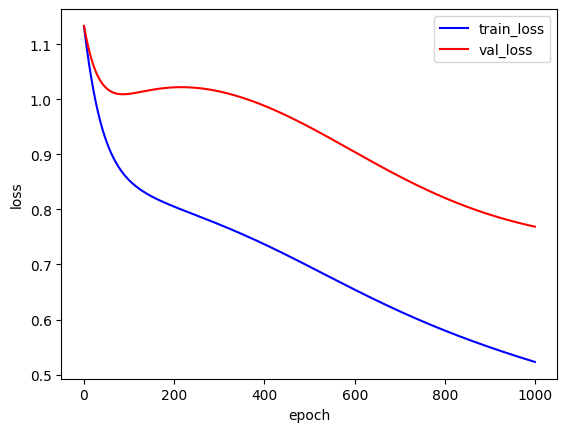

In [ ]:
history_dict = history_mlp.history
loss_train_epochs = history_dict['loss']
loss_val_epochs = history_dict['val_loss']

plt.figure()
plt.plot(loss_train_epochs,color='blue',label='train_loss')
plt.plot(loss_val_epochs,color='red',label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('epoch-loss.pdf')
plt.show()
plt.close()

### Choisir le modèle sauveguardé

In [ ]:
model = tf.keras.models.load_model('best-model.h5')

### Évaluer l'accuracy de ce meilleur modèle sur le test

In [ ]:
loss,acc = model.evaluate(x_test,y_test)

print("L'accuracy sur l'ensemble du test est:",acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - accuracy: 0.7500 - loss: 0.5638
L'accuracy sur l'ensemble du test est: 0.75


### **Exercices**

#### Essayez d'améliorer le modèle en ajoutant une couche caché de 16 neurones et comparez les résultats:




In [ ]:
# Votre code ici

#### Essayez d'enlever les fonctions d'activation dans les couches cachées (activation='linear') et comparez les résultats

In [ ]:
# Votre code ici

## Régression

### Jeu de données synthétique

Nous allons créer un jeu de données synthétique représentant la fonction non linéaire à estimer par le MLP.

In [ ]:
# Create data with equation y=0.1*x*x*sin(x)
x_data = np.linspace(-10, 10, num=1000)
y_data = 0.1*x_data*x_data*np.sin(x_data) + 0.5*np.random.normal(size=1000)

Affichage du jeu de données

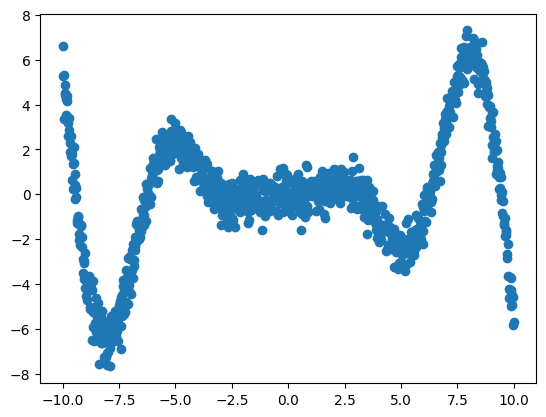

In [ ]:
plt.scatter(x_data,y_data)

Ajout d'une dimension aux données pour être compatible avec Keras

In [ ]:
x_data = np.expand_dims(x_data,axis=1)
y_data = np.expand_dims(y_data,axis=1)

### Création d'un modèle de regression non linéaire avec Keras

Le modèle contient une couche cachée de 64 neurones.

In [ ]:
input_layer = tf.keras.layers.Input(shape=(x_data.shape[1],))
hidden_layer = tf.keras.layers.Dense(units=64,activation='relu')(input_layer)
output_layer = tf.keras.layers.Dense(units=1, activation='linear')(hidden_layer)

multi_layer_model_regression = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
multi_layer_model_regression.summary()
multi_layer_model_regression.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

### Entrainement du modèle

In [ ]:
nb_epochs = 1000
history = multi_layer_model_regression.fit(x_data,y_data,epochs=nb_epochs,verbose=True)

Epoch 1/1000
32/32 [==============================] - 2s 3ms/step - loss: 6.9767
Epoch 2/1000
32/32 [==============================] - 0s 3ms/step - loss: 6.7593
Epoch 3/1000
32/32 [==============================] - 0s 3ms/step - loss: 6.5113
Epoch 4/1000
32/32 [==============================] - 0s 3ms/step - loss: 6.7603
Epoch 5/1000
32/32 [==============================] - 0s 3ms/step - loss: 6.5342
Epoch 6/1000
32/32 [==============================] - 0s 3ms/step - loss: 6.6338
Epoch 7/1000
32/32 [==============================] - 0s 3ms/step - loss: 6.4975
Epoch 8/1000
32/32 [==============================] - 0s 3ms/step - loss: 6.3211
Epoch 9/1000
32/32 [==============================] - 0s 3ms/step - loss: 6.7013
Epoch 10/1000
32/32 [==============================] - 0s 3ms/step - loss: 6.4951
Epoch 11/1000
32/32 [==============================] - 0s 3ms/step - loss: 6.4895
Epoch 12/1000
32/32 [==============================] - 0s 3ms/step - loss: 6.3004
Epoch 13/1000
32/32 [====

Courbe d'erreur sur le train en fonction du nombre d'époques

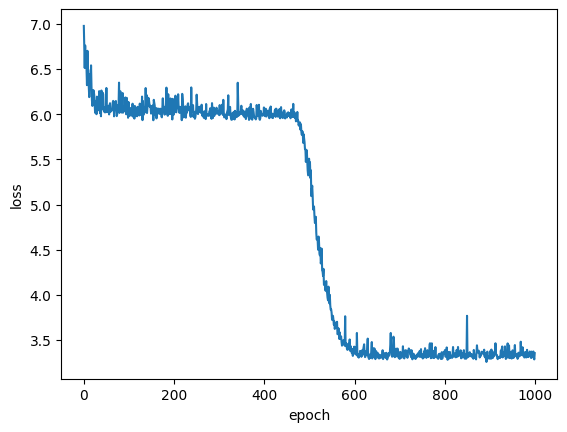

In [ ]:
history_dict = history.history
loss_epochs = history_dict['loss']

plt.figure()
plt.plot(loss_epochs)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.close()

### Evaluation du modèle

In [ ]:
loss = multi_layer_model_regression.evaluate(x_data,y_data,verbose=False)

print("Le taux d'erreur sur l'ensemble du test est:",loss)

Le taux d'erreur sur l'ensemble du test est: 3.2885677814483643


Affichage de la courbe de prédiction

32/32 [==============================] - 0s 1ms/step


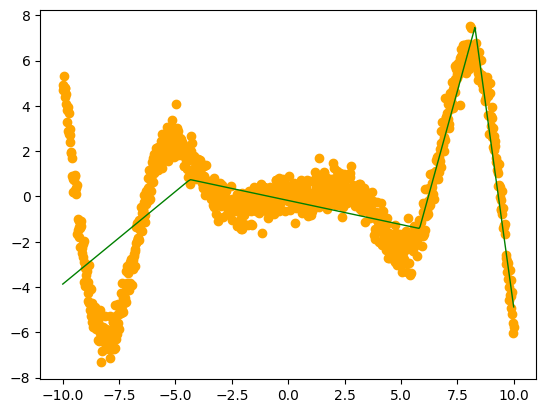

In [ ]:
# Compute the output
y_predicted = multi_layer_model_regression.predict(x_data)

# Display the result
plt.scatter(x_data[::1], y_data[::1], color='orange')
plt.plot(x_data, y_predicted, 'g', linewidth=1)

### **Exercice**

#### Ajoutez une deuxième couche cachée de 64 neurones et comparez les prédictions

In [ ]:
#votre code ici
